In [1]:
#libraries used
import numpy as np
from numpy import array
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
from scipy import stats
from scipy import signal
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data reading
train_data = read_csv(r'C:\Users\User\Desktop\Projects\Time_Series\Daily_Climate\Data\DailyDelhiClimateTrain.csv')
test_data = read_csv(r'C:\Users\User\Desktop\Projects\Time_Series\Daily_Climate\Data\DailyDelhiClimateTest.csv')

In [3]:
train_data

date   meantemp    humidity  wind_speed  meanpressure
0     2013-01-01  10.000000   84.500000    0.000000   1015.666667
1     2013-01-02   7.400000   92.000000    2.980000   1017.800000
2     2013-01-03   7.166667   87.000000    4.633333   1018.666667
3     2013-01-04   8.666667   71.333333    1.233333   1017.166667
4     2013-01-05   6.000000   86.833333    3.700000   1016.500000
...          ...        ...         ...         ...           ...
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 5 columns]

In [4]:
test_data

date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   1018.277778
2    2017-01-03  17.111111  81.888889    4.016667   1018.333333
3    2017-01-04  18.700000  70.050000    4.545000   1015.700000
4    2017-01-05  18.388889  74.944444    3.300000   1014.333333
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 5 columns]

In [5]:
#Converting to date-time format
train_data['date'] = pd.to_datetime(train_data['date'])

In [6]:
#checking for missing data
print(train_data.isnull().sum())

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [7]:
years = [train_data['date'][i].year for i in range(len(train_data['date']))]
months = [train_data['date'][i].month for i in range(len(train_data['date']))]

In [8]:
print('Number of appearances for each year:',Counter(years))

Number of appearances for each year: Counter({2016: 366, 2013: 365, 2014: 365, 2015: 365, 2017: 1})


In [9]:
print('Number of appearances for each month:',Counter(months))

Number of appearances for each month: Counter({1: 125, 3: 124, 5: 124, 7: 124, 8: 124, 10: 124, 12: 124, 4: 120, 6: 120, 9: 120, 11: 120, 2: 113})


As it can be seen, the data is not temporarly equidistant (some moths are missing/dubled in some years).

In [10]:
temperature = train_data['meantemp']
humidity = train_data['humidity']
windspeed = train_data['wind_speed']
pressure = train_data['meanpressure']

As ussual let's start with some EDA.

## EDA

In the beggining, let's work with each feature individually.

### Temperature

#### Statistics

In [11]:
print('The mean of the temperature values is:', np.mean(temperature))
print('The median of the temperature values is:', np.median(temperature))
print('The mode of the temperature values is:', statistics.mode(temperature))
print('Standard deviation of the temperature values:', np.std(temperature))
print('Quartiles:',np.quantile(temperature,[0,0.25,0.5,0.75,1]))

The mean of the temperature values is: 25.495520655761762
The median of the temperature values is: 27.714285714285715
The mode of the temperature values is: 31.0
Standard deviation of the temperature values: 7.345589264532731
Quartiles: [ 6.         18.85714286 27.71428571 31.30580357 38.71428571]


#### Boxplots, Runplots and Piecharts

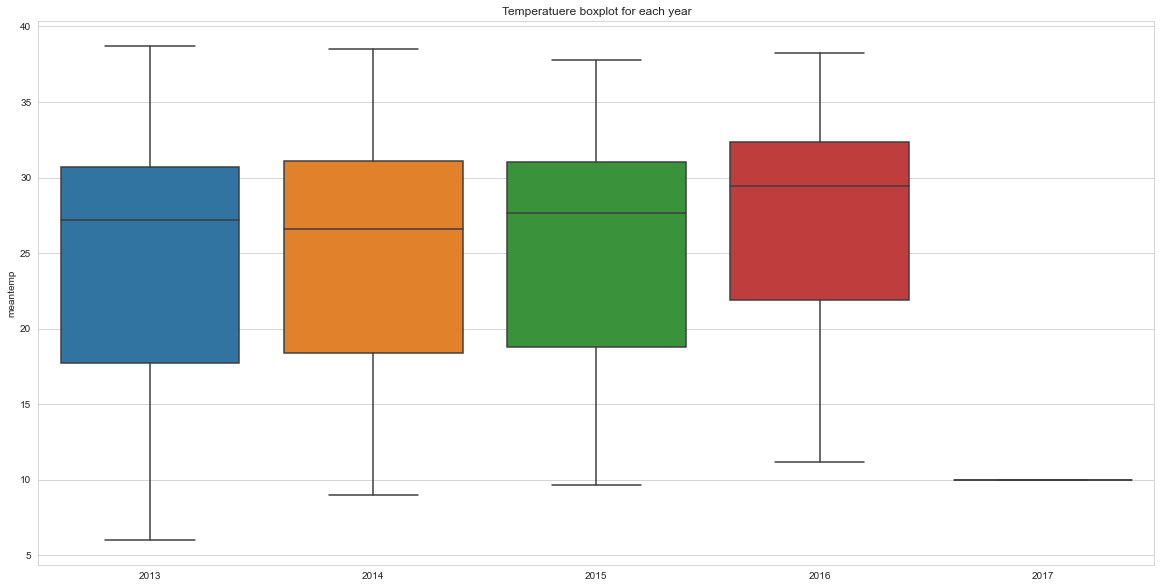

In [12]:
#Boxplots for each year
plt.figure(figsize = (20,10))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = temperature)
ax.set_title('Temperatuere boxplot for each year')
plt.show()

A little increasment can be observed, but more data is needed to take a valid conclusion. In ored to see if we realy have an increasement in temperature values, let's use the runplots of the temperature for each year.

In [13]:
temp_2013 = [train_data['meantemp'][i] for i in range(len(temperature)) if train_data['date'][i].year == 2013]
temp_2014 = [train_data['meantemp'][i] for i in range(len(temperature)) if train_data['date'][i].year == 2014]
temp_2015 = [train_data['meantemp'][i] for i in range(len(temperature)) if train_data['date'][i].year == 2015]
temp_2016 = [train_data['meantemp'][i] for i in range(len(temperature)) if train_data['date'][i].year == 2016]

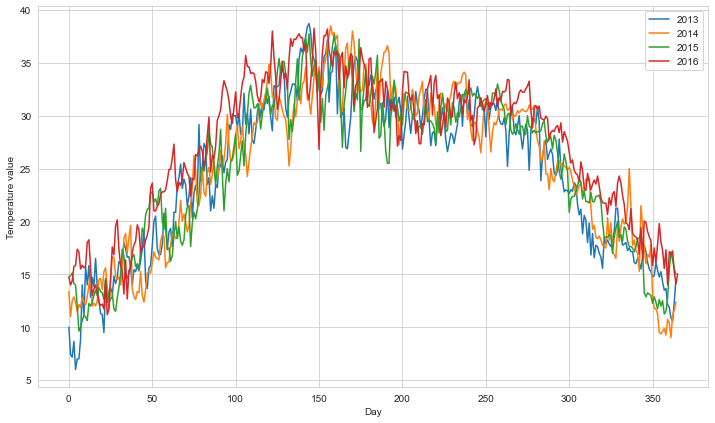

In [14]:
plt.figure(figsize = (12,7))
plt.plot(temp_2013)
plt.plot(temp_2014)
plt.plot(temp_2015)
plt.plot(temp_2016)
plt.xlabel('Day')
plt.ylabel('Temperature value')
plt.grid(True)
plt.legend(['2013','2014','2015','2016'], loc = 'best')
plt.show()

Max for 2013:  36
Max for 2014:  67
Max for 2015:  54
Max for 2016:  210


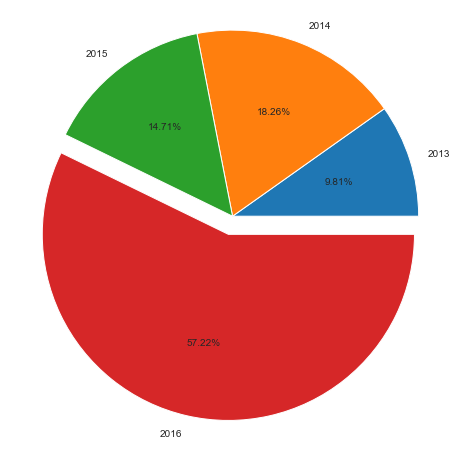

In [15]:
s1 = 0
s2 = 0
s3 = 0
s4 = 0
for i in range(len(temp_2013)):
    v1 = temp_2013[i]
    v2 = temp_2014[i]
    v3 = temp_2015[i]
    v4 = temp_2016[i]
    seq = [v1,v2,v3,v4]
    if max(seq) == v1:
        s1 += 1
    if max(seq) == v2:
        s2 += 1
    if max(seq) == v3:
        s3 += 1
    if max(seq) == v4:
        s4 += 1
print('Max for 2013: ',s1)
print('Max for 2014: ',s2)
print('Max for 2015: ',s3)
print('Max for 2016: ',s4)
#pie_chart containing the max temp for a specific day for 2013, 2014, 2015, 2016
sizes = [s1,s2,s3,s4]
labels = ['2013', '2014', '2015', '2016']
plt.figure(figsize = (8,8))
plt.pie(sizes, labels = labels, autopct='%1.2f%%', explode=(0.0, 0.0, 0.0, 0.1))
plt.axis('equal')
plt.show()

Values form 2016 are a little bit bigger than in previous years, which confirms the statement above.

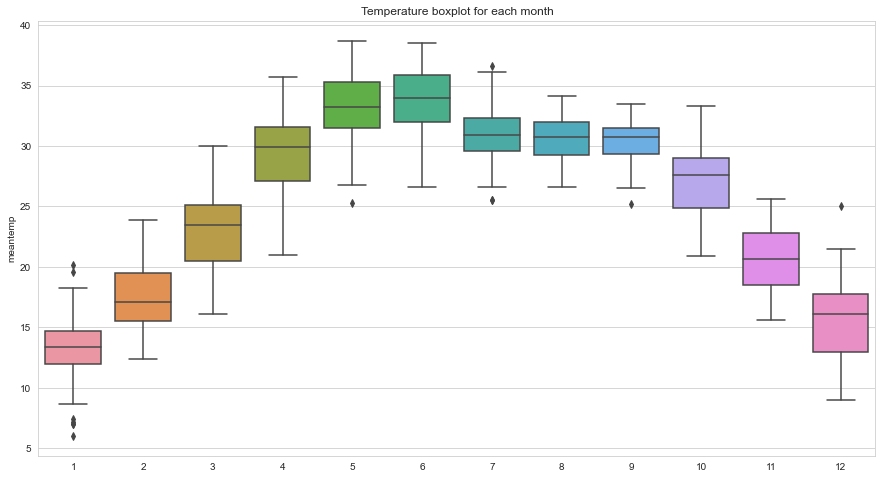

In [16]:
#Boxplots for each month
plt.figure(figsize = (15,8))
sns.set_style('whitegrid')
ax = sns.boxplot(x = months, y = temperature)
ax.set_title('Temperature boxplot for each month')
plt.show()

As excpected, warm during summer, cold during winter.

#### Histogram and top 5 best fitted distributions

---------------------------------------------  All years Temperature distribution ---------------------------------------------
The best fitted distribution for the temperature data is: {'exponpow': {'b': 2.994647559793239, 'loc': 2.0425613500367596, 'scale': 30.126351429278674}}


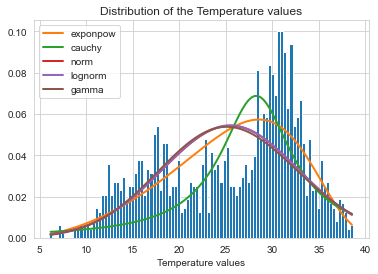

---------------------------------------------  2013 Temperature distribution ---------------------------------------------
The best fitted distribution for the 2013 temperature data is: {'exponpow': {'b': 2.973306905781421, 'loc': 1.0801925229947351, 'scale': 30.482606182077134}}


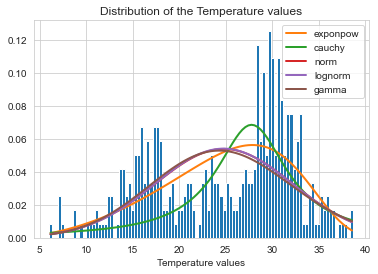

---------------------------------------------  2014 Temperature distribution ---------------------------------------------
The best fitted distribution for the 2014 temperature data is: {'powerlaw': {'a': 1.2291477964237225, 'loc': 8.954677209163675, 'scale': 29.568794130476636}}


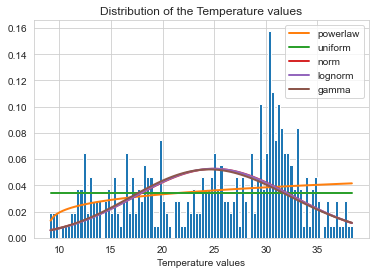

---------------------------------------------  2015 Temperature distribution ---------------------------------------------
The best fitted distribution for the 2015 temperature data is: {'powerlaw': {'a': 1.5733779633392402, 'loc': 6.834687679452664, 'scale': 30.915312326122255}}


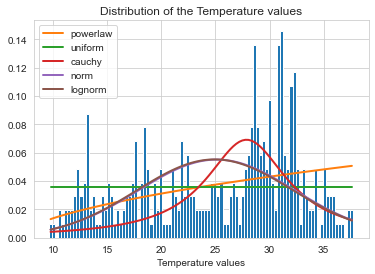

---------------------------------------------  2016 Temperature distribution ---------------------------------------------
The best fitted distribution for the 2016 temperature data is: {'powerlaw': {'a': 1.7546286406363878, 'loc': 8.576140543666767, 'scale': 29.696586730406977}}


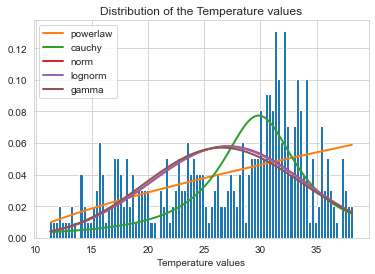

In [17]:
print('---------------------------------------------  All years Temperature distribution ---------------------------------------------')
f = Fitter(temperature,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the temperature data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Temperature values')
plt.title('Distribution of the Temperature values')
plt.show()

print('---------------------------------------------  2013 Temperature distribution ---------------------------------------------')
f = Fitter(temp_2013,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2013 temperature data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Temperature values')
plt.title('Distribution of the Temperature values')
plt.show()

print('---------------------------------------------  2014 Temperature distribution ---------------------------------------------')
f = Fitter(temp_2014,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2014 temperature data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Temperature values')
plt.title('Distribution of the Temperature values')
plt.show()

print('---------------------------------------------  2015 Temperature distribution ---------------------------------------------')
f = Fitter(temp_2015,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2015 temperature data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Temperature values')
plt.title('Distribution of the Temperature values')
plt.show()

print('---------------------------------------------  2016 Temperature distribution ---------------------------------------------')
f = Fitter(temp_2016,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2016 temperature data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Temperature values')
plt.title('Distribution of the Temperature values')
plt.show()

Similar distributions for each year temperature data sample.

#### Autocorrelation plot

<Figure size 432x288 with 0 Axes>

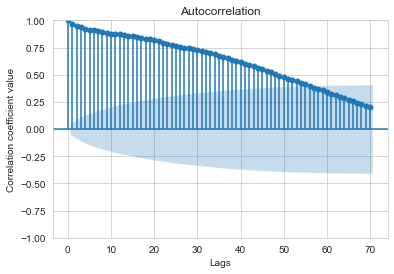

In [18]:
plt.figure()
plot_acf(x = temperature, lags=70)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient value')
plt.show()

As expected, a linear decreasing autocorrelation plot.

Let's also check for some eventual frequency in the temperature data.

#### PSD

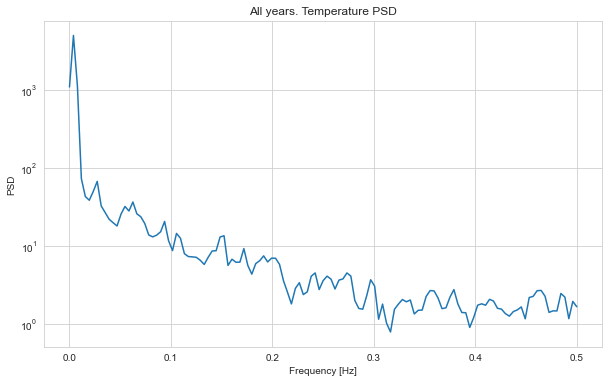

Text(0.5, 1.0, 'Temperature 2016')

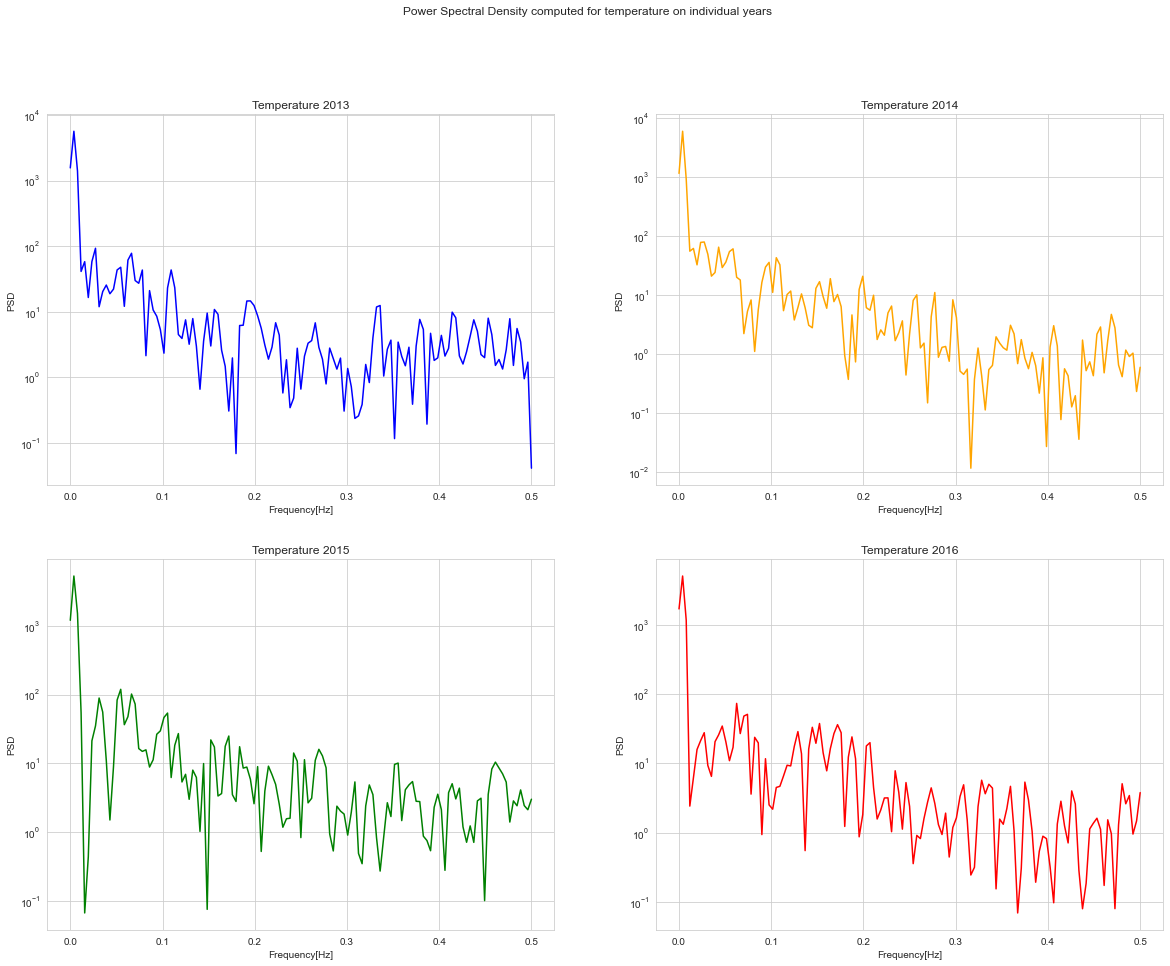

In [19]:
freq, psd = signal.welch(temperature)
plt.figure(figsize = (10,6))
plt.semilogy(freq, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('All years. Temperature PSD')
plt.show()

f_2013, p_2013 = signal.welch(temp_2013)
f_2014, p_2014 = signal.welch(temp_2014)
f_2015, p_2015 = signal.welch(temp_2015)
f_2016, p_2016 = signal.welch(temp_2016)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize = (20,15))
fig.suptitle('Power Spectral Density computed for temperature on individual years')

ax1.semilogy(f_2013,p_2013,c='blue')
ax1.set_xlabel('Frequency[Hz]')
ax1.set_ylabel('PSD')
ax1.set_title('Temperature 2013')

ax2.semilogy(f_2014,p_2014,c='orange')
ax2.set_xlabel('Frequency[Hz]')
ax2.set_ylabel('PSD')
ax2.set_title('Temperature 2014')

ax3.semilogy(f_2015,p_2015,c='green')
ax3.set_xlabel('Frequency[Hz]')
ax3.set_ylabel('PSD')
ax3.set_title('Temperature 2015')

ax4.semilogy(f_2016,p_2016,c='red')
ax4.set_xlabel('Frequency[Hz]')
ax4.set_ylabel('PSD')
ax4.set_title('Temperature 2016')

No significant peaks can be observed. Therefore we cannot say that there is a certain frequency for the temperature data.

Now, let's do the same thing for the other features.

### Humidity

#### Statistics

In [20]:
print('The mean of the humidity values is:', np.mean(humidity))
print('The median of the humidity values is:', np.median(humidity))
print('The mode of the humidity values is:', statistics.mode(humidity))
print('Standard deviation of the humidity values:', np.std(humidity))
print('Quartiles:',np.quantile(humidity,[0,0.25,0.5,0.75,1]))

The mean of the humidity values is: 60.77170158004638
The median of the humidity values is: 62.625
The mode of the humidity values is: 65.5
Standard deviation of the humidity values: 16.76391611224823
Quartiles: [ 13.42857143  50.375       62.625       72.21875    100.        ]


#### Boxplots, Runplots and Piecharts

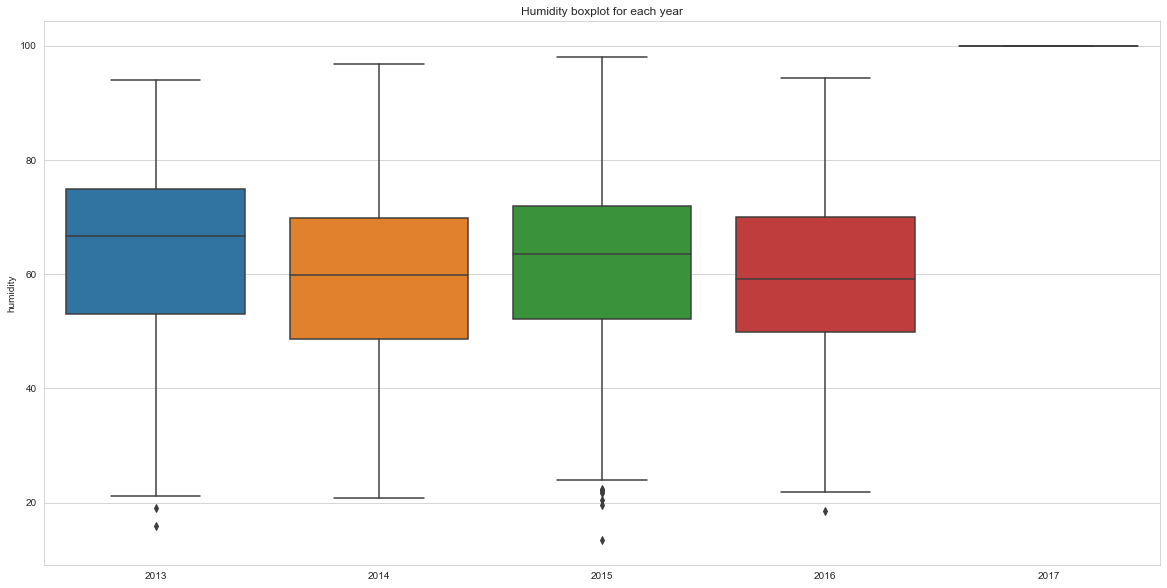

In [21]:
#Boxplots for each year
plt.figure(figsize = (20,10))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = humidity)
ax.set_title('Humidity boxplot for each year')
plt.show()

In [22]:
hum_2013 = [train_data['humidity'][i] for i in range(len(humidity)) if train_data['date'][i].year == 2013]
hum_2014 = [train_data['humidity'][i] for i in range(len(humidity)) if train_data['date'][i].year == 2014]
hum_2015 = [train_data['humidity'][i] for i in range(len(humidity)) if train_data['date'][i].year == 2015]
hum_2016 = [train_data['humidity'][i] for i in range(len(humidity)) if train_data['date'][i].year == 2016]

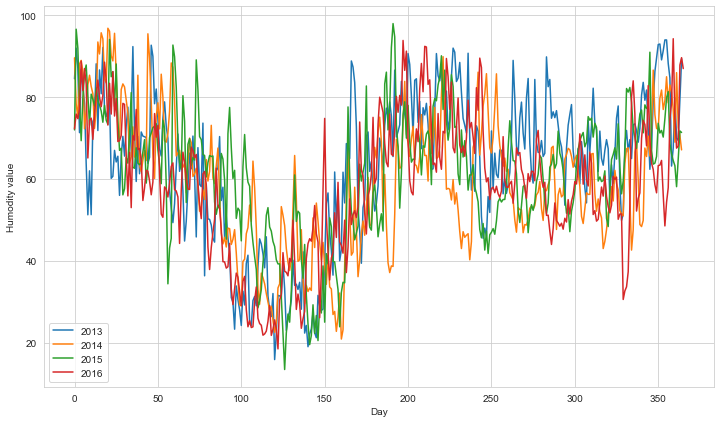

In [23]:
plt.figure(figsize = (12,7))
plt.plot(hum_2013)
plt.plot(hum_2014)
plt.plot(hum_2015)
plt.plot(hum_2016)
plt.xlabel('Day')
plt.ylabel('Humodity value')
plt.grid(True)
plt.legend(['2013','2014','2015','2016'], loc = 'best')
plt.show()

Max for 2013:  123
Max for 2014:  85
Max for 2015:  93
Max for 2016:  64


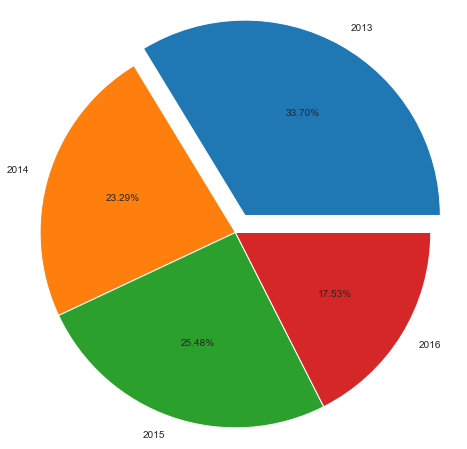

In [24]:
s1 = 0
s2 = 0
s3 = 0
s4 = 0
for i in range(len(hum_2013)):
    v1 = hum_2013[i]
    v2 = hum_2014[i]
    v3 = hum_2015[i]
    v4 = hum_2016[i]
    seq = [v1,v2,v3,v4]
    if max(seq) == v1:
        s1 += 1
    if max(seq) == v2:
        s2 += 1
    if max(seq) == v3:
        s3 += 1
    if max(seq) == v4:
        s4 += 1
print('Max for 2013: ',s1)
print('Max for 2014: ',s2)
print('Max for 2015: ',s3)
print('Max for 2016: ',s4)
#pie_chart containing the max humidity for a specific day for 2013, 2014, 2015, 2016
sizes = [s1,s2,s3,s4]
labels = ['2013', '2014', '2015', '2016']
plt.figure(figsize = (8,8))
plt.pie(sizes, labels = labels, autopct='%1.2f%%', explode=(0.1, 0.0, 0.0, 0.0))
plt.axis('equal')
plt.show()

Small decreasing trend in time.

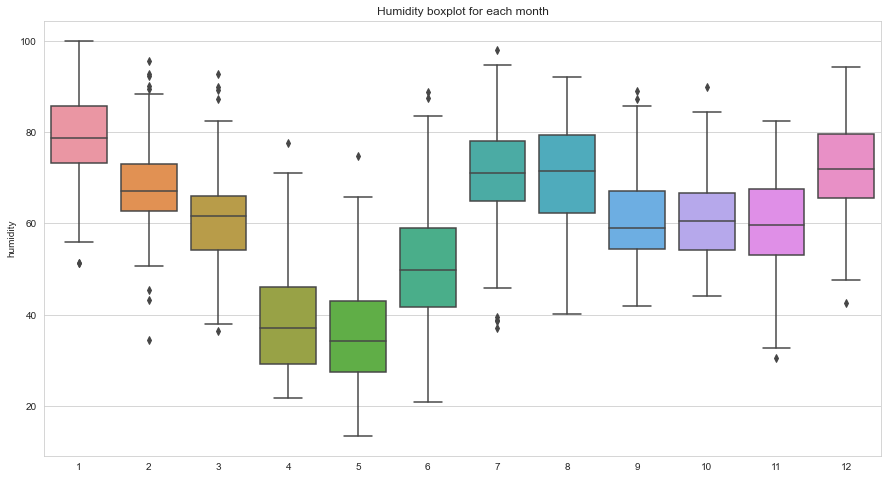

In [25]:
#Boxplots for each month
plt.figure(figsize = (15,8))
sns.set_style('whitegrid')
ax = sns.boxplot(x = months, y = humidity)
ax.set_title('Humidity boxplot for each month')
plt.show()

#### Histogram and top 5 best fitted distributions

---------------------------------------------  All years Humidity distribution ---------------------------------------------
The best fitted distribution for the humidity data is: {'exponpow': {'b': 2.5770557999872716, 'loc': 9.563714010479822, 'scale': 68.82274217136941}}


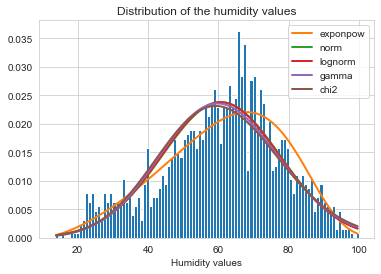

---------------------------------------------  2013 Humidity distribution ---------------------------------------------
The best fitted distribution for the 2013 humidity data is: {'cauchy': {'loc': 67.67781498411969, 'scale': 9.739314383870862}}


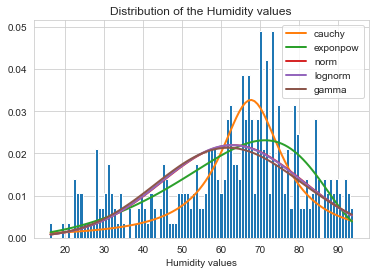

---------------------------------------------  2014 Humidity distribution ---------------------------------------------
The best fitted distribution for the 2014 humidity data is: {'norm': {'loc': 59.76794180000767, 'scale': 16.19865119309871}}


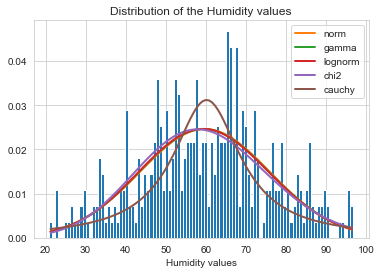

---------------------------------------------  2015 Humidity distribution ---------------------------------------------
The best fitted distribution for the 2015 humidity data is: {'powerlaw': {'a': 1.5733779633392402, 'loc': 6.834687679452664, 'scale': 30.915312326122255}}


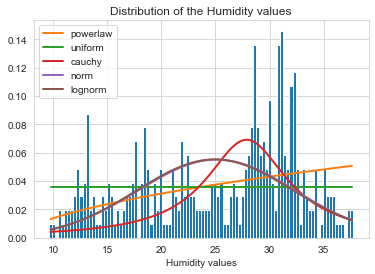

---------------------------------------------  2016 Humidity distribution ---------------------------------------------
The best fitted distribution for the 2016 humidity data is: {'norm': {'loc': 58.74017392187424, 'scale': 16.489708096429336}}


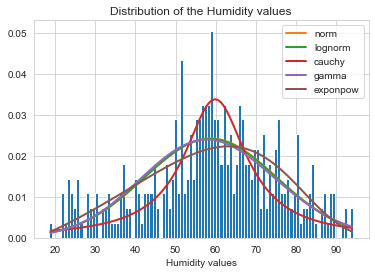

In [26]:
print('---------------------------------------------  All years Humidity distribution ---------------------------------------------')
f = Fitter(humidity,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the humidity data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Humidity values')
plt.title('Distribution of the humidity values')
plt.show()

print('---------------------------------------------  2013 Humidity distribution ---------------------------------------------')
f = Fitter(hum_2013,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2013 humidity data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Humidity values')
plt.title('Distribution of the Humidity values')
plt.show()

print('---------------------------------------------  2014 Humidity distribution ---------------------------------------------')
f = Fitter(hum_2014,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2014 humidity data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Humidity values')
plt.title('Distribution of the Humidity values')
plt.show()

print('---------------------------------------------  2015 Humidity distribution ---------------------------------------------')
f = Fitter(temp_2015,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2015 humidity data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Humidity values')
plt.title('Distribution of the Humidity values')
plt.show()

print('---------------------------------------------  2016 Humidity distribution ---------------------------------------------')
f = Fitter(hum_2016,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2016 humidity data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Humidity values')
plt.title('Distribution of the Humidity values')
plt.show()

Only temperature data smaples distributions from two years are similar.

#### Autocorrelation plot

<Figure size 432x288 with 0 Axes>

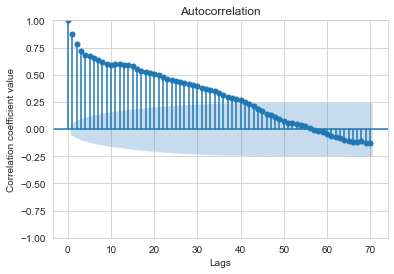

In [27]:
plt.figure()
plot_acf(x = humidity, lags=70)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient value')
plt.show()

#### PSD

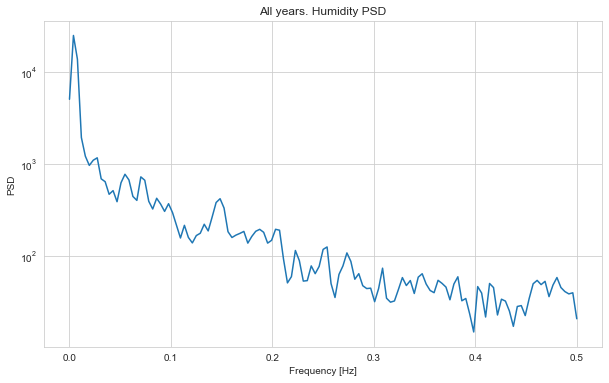

Text(0.5, 1.0, 'Humidity 2016')

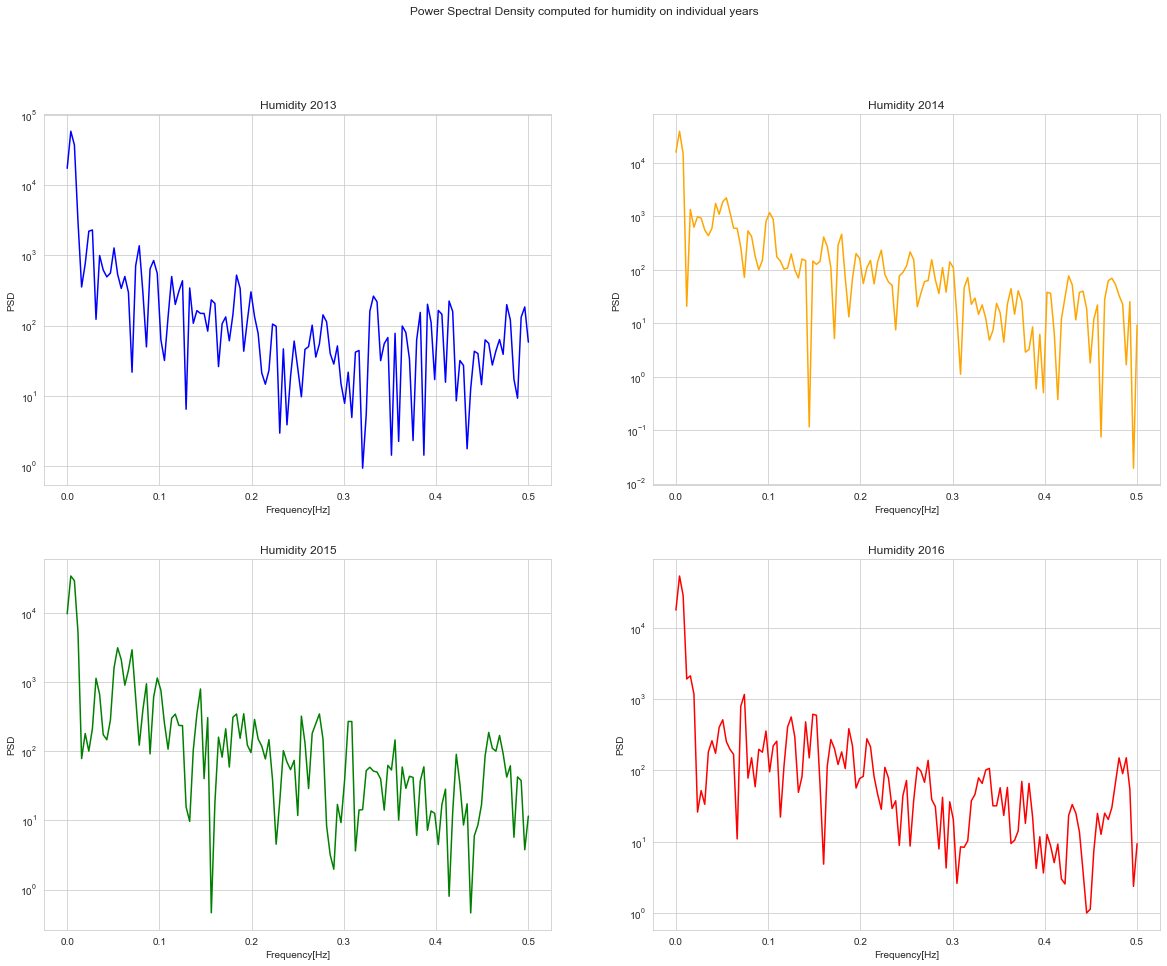

In [28]:
freq, psd = signal.welch(humidity)
plt.figure(figsize = (10,6))
plt.semilogy(freq, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('All years. Humidity PSD')
plt.show()

f_2013, p_2013 = signal.welch(hum_2013)
f_2014, p_2014 = signal.welch(hum_2014)
f_2015, p_2015 = signal.welch(hum_2015)
f_2016, p_2016 = signal.welch(hum_2016)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize = (20,15))
fig.suptitle('Power Spectral Density computed for humidity on individual years')

ax1.semilogy(f_2013,p_2013,c='blue')
ax1.set_xlabel('Frequency[Hz]')
ax1.set_ylabel('PSD')
ax1.set_title('Humidity 2013')

ax2.semilogy(f_2014,p_2014,c='orange')
ax2.set_xlabel('Frequency[Hz]')
ax2.set_ylabel('PSD')
ax2.set_title('Humidity 2014')

ax3.semilogy(f_2015,p_2015,c='green')
ax3.set_xlabel('Frequency[Hz]')
ax3.set_ylabel('PSD')
ax3.set_title('Humidity 2015')

ax4.semilogy(f_2016,p_2016,c='red')
ax4.set_xlabel('Frequency[Hz]')
ax4.set_ylabel('PSD')
ax4.set_title('Humidity 2016')

No significant peak can be observed in the PSD plots. Therefore, no frequency can be deduced.

### Wind Speed

#### Statistics

In [29]:
print('The mean of the wind speed values is:', np.mean(windspeed))
print('The median of the wind speed values is:', np.median(windspeed))
print('The mode of the wind speed values is:', statistics.mode(windspeed))
print('Standard deviation of the windspeed values:', np.std(windspeed))
print('Quartiles:',np.quantile(windspeed,[0,0.25,0.5,0.75,1]))

The mean of the wind speed values is: 6.8022087474474695
The median of the wind speed values is: 6.221666666666667
The mode of the wind speed values is: 0.0
Standard deviation of the windspeed values: 4.560041841953647
Quartiles: [ 0.          3.475       6.22166667  9.23823529 42.22      ]


#### Boxplots, Runplots and Piecharts

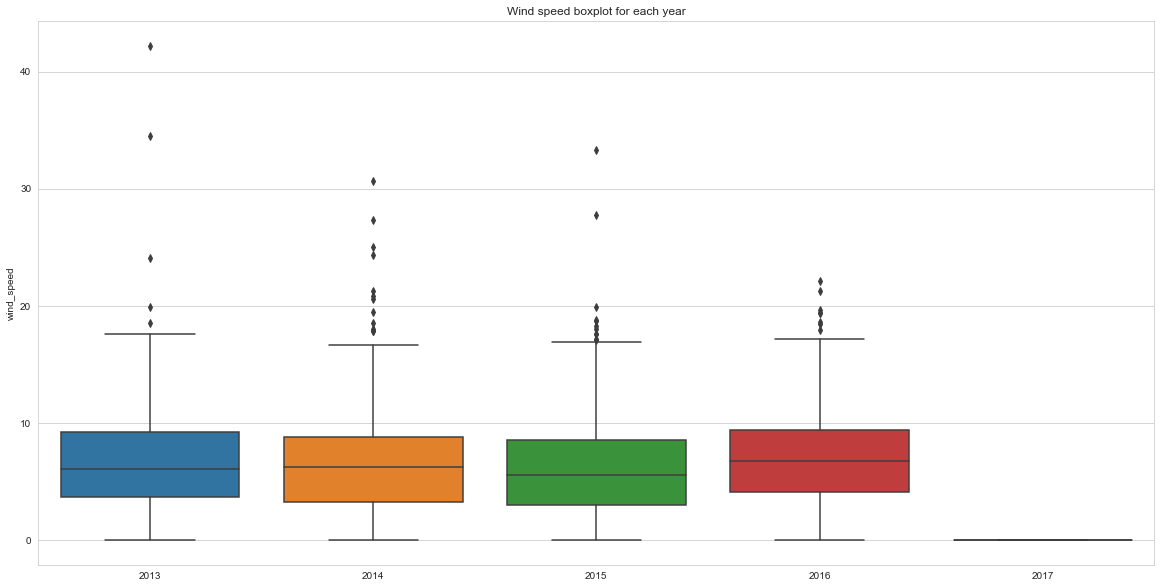

In [30]:
#Boxplots for each year
plt.figure(figsize = (20,10))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = windspeed)
ax.set_title('Wind speed boxplot for each year')
plt.show()

In [31]:
ws_2013 = [train_data['wind_speed'][i] for i in range(len(windspeed)) if train_data['date'][i].year == 2013]
ws_2014 = [train_data['wind_speed'][i] for i in range(len(windspeed)) if train_data['date'][i].year == 2014]
ws_2015 = [train_data['wind_speed'][i] for i in range(len(windspeed)) if train_data['date'][i].year == 2015]
ws_2016 = [train_data['wind_speed'][i] for i in range(len(windspeed)) if train_data['date'][i].year == 2016]

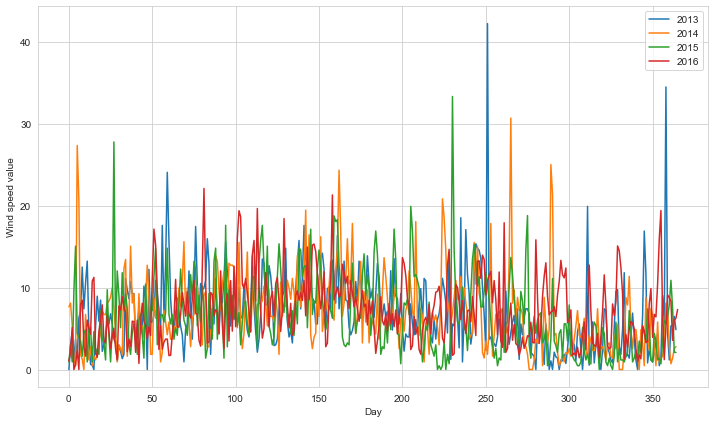

In [32]:
plt.figure(figsize = (12,7))
plt.plot(ws_2013)
plt.plot(ws_2014)
plt.plot(ws_2015)
plt.plot(ws_2016)
plt.xlabel('Day')
plt.ylabel('Wind speed value')
plt.grid(True)
plt.legend(['2013','2014','2015','2016'], loc = 'best')
plt.show()

Max for 2013:  83
Max for 2014:  96
Max for 2015:  76
Max for 2016:  110


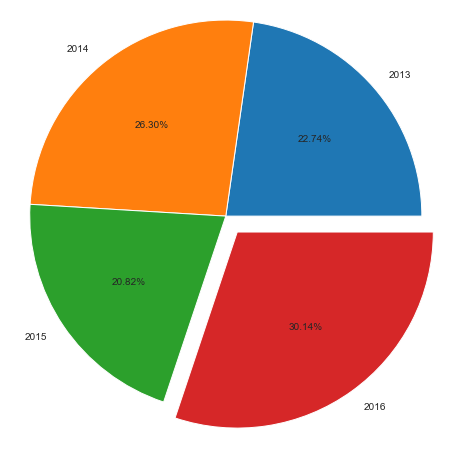

In [33]:
s1 = 0
s2 = 0
s3 = 0
s4 = 0
for i in range(len(ws_2013)):
    v1 = ws_2013[i]
    v2 = ws_2014[i]
    v3 = ws_2015[i]
    v4 = ws_2016[i]
    seq = [v1,v2,v3,v4]
    if max(seq) == v1:
        s1 += 1
    if max(seq) == v2:
        s2 += 1
    if max(seq) == v3:
        s3 += 1
    if max(seq) == v4:
        s4 += 1
print('Max for 2013: ',s1)
print('Max for 2014: ',s2)
print('Max for 2015: ',s3)
print('Max for 2016: ',s4)
#pie_chart containing the max humidity for a specific day for 2013, 2014, 2015, 2016
sizes = [s1,s2,s3,s4]
labels = ['2013', '2014', '2015', '2016']
plt.figure(figsize = (8,8))
plt.pie(sizes, labels = labels, autopct='%1.2f%%', explode=(0.0, 0.0, 0.0, 0.1))
plt.axis('equal')
plt.show()

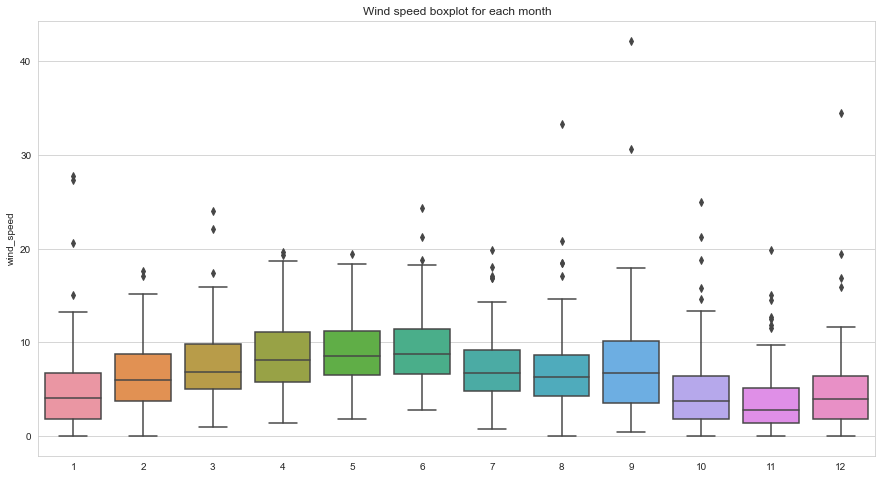

In [34]:
#Boxplots for each month
plt.figure(figsize = (15,8))
sns.set_style('whitegrid')
ax = sns.boxplot(x = months, y = windspeed)
ax.set_title('Wind speed boxplot for each month')
plt.show()

---------------------------------------------  All years Wind speed distribution ---------------------------------------------
The best fitted distribution for the wind speed data is: {'rayleigh': {'loc': -1.0573952951231969, 'scale': 6.425237633985268}}


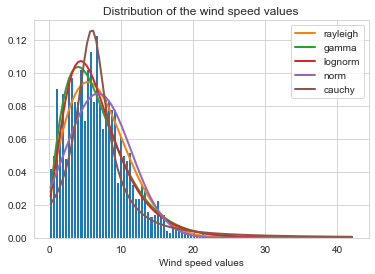

---------------------------------------------  2013 wind speed distribution ---------------------------------------------
The best fitted distribution for the 2013 wind speed data is: {'rayleigh': {'loc': -1.3020074533244939, 'scale': 6.682710675405072}}


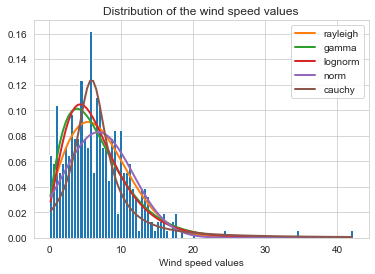

---------------------------------------------  2014 wind speed distribution ---------------------------------------------
The best fitted distribution for the 2014 wind speed data is: {'rayleigh': {'loc': -1.164174006082808, 'scale': 6.496215670886416}}


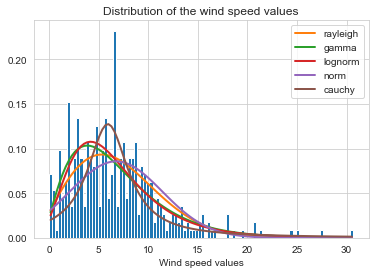

---------------------------------------------  2015 wind speed distribution ---------------------------------------------
The best fitted distribution for the 2015 wind speed data is: {'gamma': {'a': 1.8718656761114585, 'loc': -0.26001285587370837, 'scale': 3.6009967683525517}}


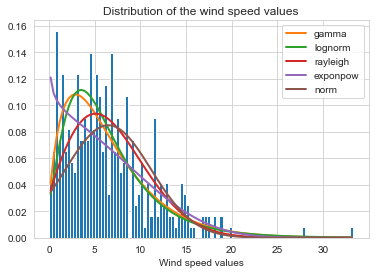

---------------------------------------------  2016 wind speed distribution ---------------------------------------------
The best fitted distribution for the 2016 wind speed data is: {'rayleigh': {'loc': -0.27630160773777473, 'scale': 5.968686146732491}}


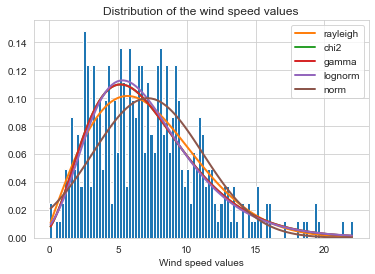

In [35]:
print('---------------------------------------------  All years Wind speed distribution ---------------------------------------------')
f = Fitter(windspeed,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the wind speed data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Wind speed values')
plt.title('Distribution of the wind speed values')
plt.show()

print('---------------------------------------------  2013 wind speed distribution ---------------------------------------------')
f = Fitter(ws_2013,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2013 wind speed data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Wind speed values')
plt.title('Distribution of the wind speed values')
plt.show()

print('---------------------------------------------  2014 wind speed distribution ---------------------------------------------')
f = Fitter(ws_2014,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2014 wind speed data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Wind speed values')
plt.title('Distribution of the wind speed values')
plt.show()

print('---------------------------------------------  2015 wind speed distribution ---------------------------------------------')
f = Fitter(ws_2015,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2015 wind speed data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Wind speed values')
plt.title('Distribution of the wind speed values')
plt.show()

print('---------------------------------------------  2016 wind speed distribution ---------------------------------------------')
f = Fitter(ws_2016,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2016 wind speed data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Wind speed values')
plt.title('Distribution of the wind speed values')
plt.show()

Similar distributions in all years.

#### Autocorrelation plot

<Figure size 432x288 with 0 Axes>

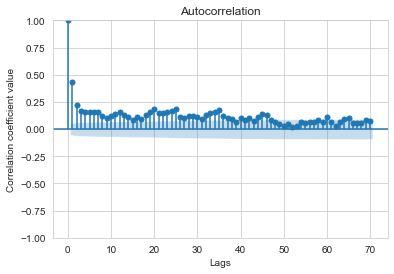

In [36]:
plt.figure()
plot_acf(x = windspeed, lags=70)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient value')
plt.show()

No significant correlation can be observed.

#### PSD

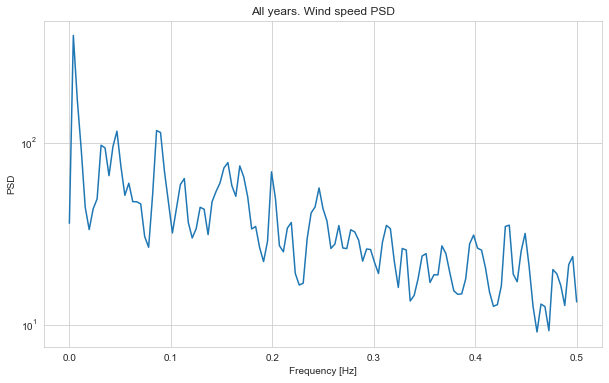

Text(0.5, 1.0, 'Wind Speed 2016')

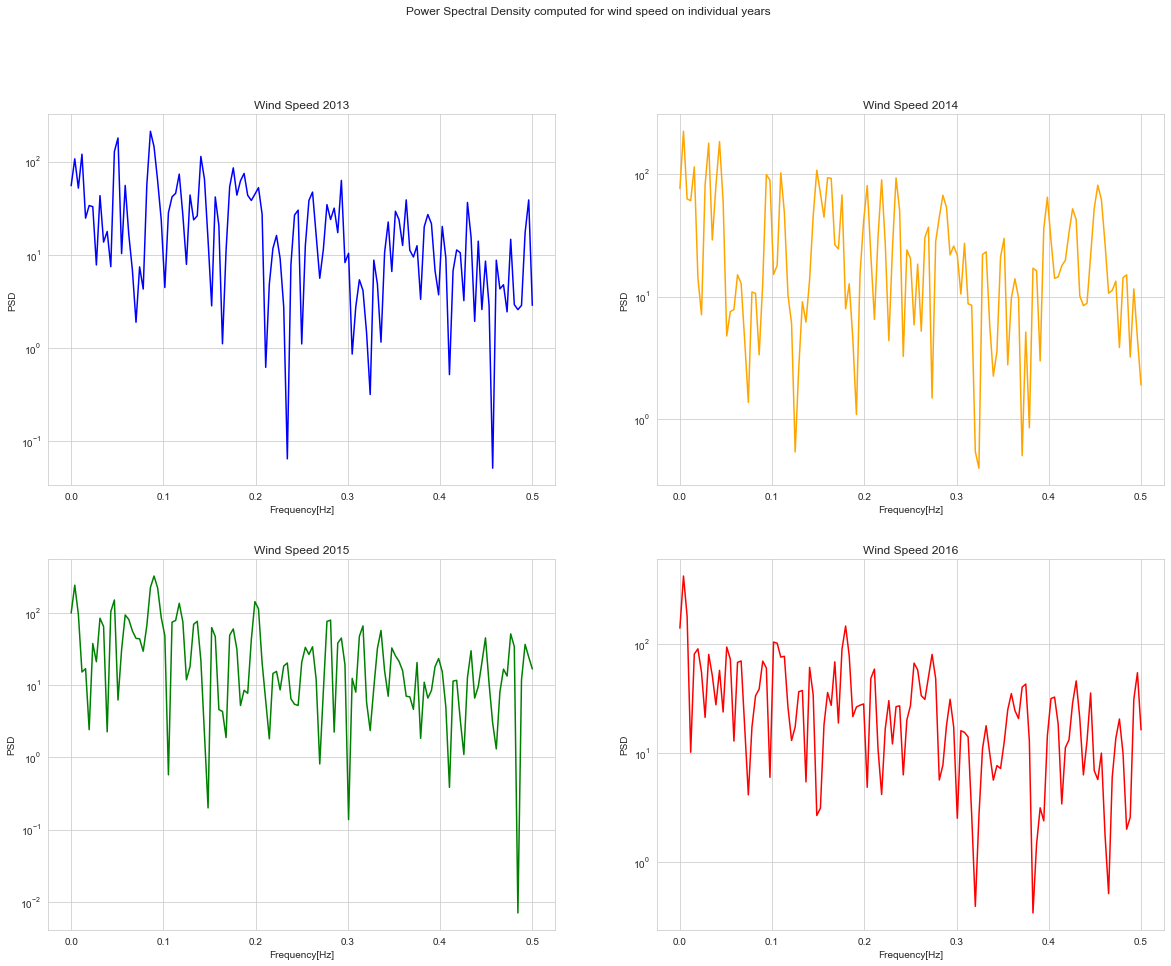

In [37]:
freq, psd = signal.welch(windspeed)
plt.figure(figsize = (10,6))
plt.semilogy(freq, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('All years. Wind speed PSD')
plt.show()

f_2013, p_2013 = signal.welch(ws_2013)
f_2014, p_2014 = signal.welch(ws_2014)
f_2015, p_2015 = signal.welch(ws_2015)
f_2016, p_2016 = signal.welch(ws_2016)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize = (20,15))
fig.suptitle('Power Spectral Density computed for wind speed on individual years')

ax1.semilogy(f_2013,p_2013,c='blue')
ax1.set_xlabel('Frequency[Hz]')
ax1.set_ylabel('PSD')
ax1.set_title('Wind Speed 2013')

ax2.semilogy(f_2014,p_2014,c='orange')
ax2.set_xlabel('Frequency[Hz]')
ax2.set_ylabel('PSD')
ax2.set_title('Wind Speed 2014')

ax3.semilogy(f_2015,p_2015,c='green')
ax3.set_xlabel('Frequency[Hz]')
ax3.set_ylabel('PSD')
ax3.set_title('Wind Speed 2015')

ax4.semilogy(f_2016,p_2016,c='red')
ax4.set_xlabel('Frequency[Hz]')
ax4.set_ylabel('PSD')
ax4.set_title('Wind Speed 2016')

No significant peak can be seen.

### Pressure

#### Statistics

In [38]:
print('The mean of the pressure values is:', np.mean(windspeed))
print('The median of the pressure values is:', np.median(windspeed))
print('The mode of the pressure values is:', statistics.mode(windspeed))
print('Standard deviation of the pressure values:', np.std(windspeed))
print('Quartiles:',np.quantile(pressure,[0,0.25,0.5,0.75,1]))

The mean of the pressure values is: 6.8022087474474695
The median of the pressure values is: 6.221666666666667
The mode of the pressure values is: 0.0
Standard deviation of the pressure values: 4.560041841953647
Quartiles: [-3.04166667e+00  1.00158036e+03  1.00856349e+03  1.01494490e+03
  7.67933333e+03]


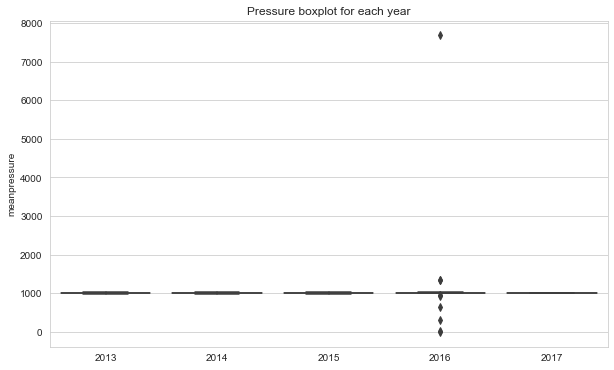

In [39]:
#Boxplots for each year
plt.figure(figsize = (10,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = pressure)
ax.set_title('Pressure boxplot for each year')
plt.show()

As it can be seen, we have some wrong values for the 2016 data, which will be replaced with the median. 

In [40]:
med_pres = np.median(pressure)
for i in range(len(pressure)):
    if pressure[i] < 975 or pressure[i] > 1075:
        pressure[i] = med_pres

#### Boxplots, Runplots and Piecharts

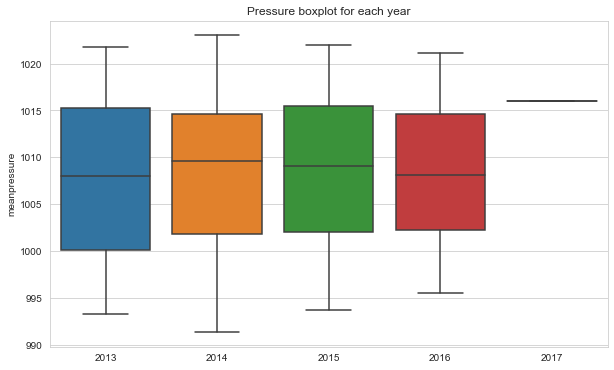

In [41]:
#Boxplots for each year
plt.figure(figsize = (10,6))
sns.set_style('whitegrid')
ax = sns.boxplot(x = years, y = pressure)
ax.set_title('Pressure boxplot for each year')
plt.show()

In [42]:
pres_2013 = [train_data['meanpressure'][i] for i in range(len(pressure)) if train_data['date'][i].year == 2013]
pres_2014 = [train_data['meanpressure'][i] for i in range(len(pressure)) if train_data['date'][i].year == 2014]
pres_2015 = [train_data['meanpressure'][i] for i in range(len(pressure)) if train_data['date'][i].year == 2015]
pres_2016 = [train_data['meanpressure'][i] for i in range(len(pressure)) if train_data['date'][i].year == 2016]

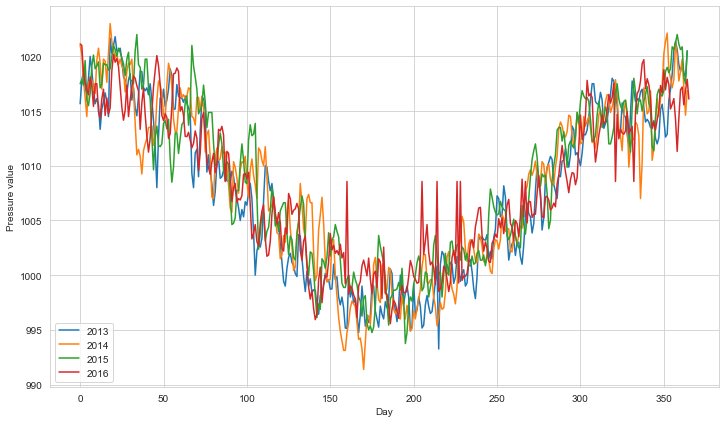

In [43]:
plt.figure(figsize = (12,7))
plt.plot(pres_2013)
plt.plot(pres_2014)
plt.plot(pres_2015)
plt.plot(pres_2016)
plt.xlabel('Day')
plt.ylabel('Pressure value')
plt.grid(True)
plt.legend(['2013','2014','2015','2016'], loc = 'best')
plt.show()

Max for 2013:  60
Max for 2014:  88
Max for 2015:  128
Max for 2016:  98


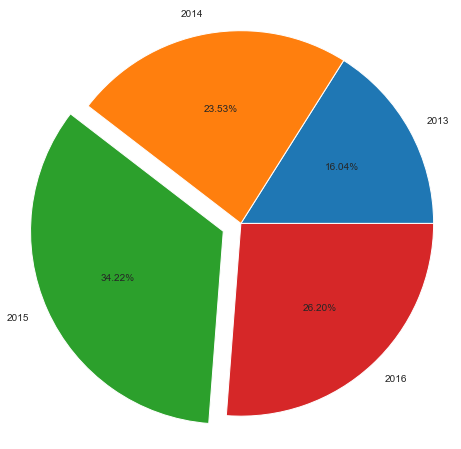

In [44]:
s1 = 0
s2 = 0
s3 = 0
s4 = 0
for i in range(len(ws_2013)):
    v1 = pres_2013[i]
    v2 = pres_2014[i]
    v3 = pres_2015[i]
    v4 = pres_2016[i]
    seq = [v1,v2,v3,v4]
    if max(seq) == v1:
        s1 += 1
    if max(seq) == v2:
        s2 += 1
    if max(seq) == v3:
        s3 += 1
    if max(seq) == v4:
        s4 += 1
print('Max for 2013: ',s1)
print('Max for 2014: ',s2)
print('Max for 2015: ',s3)
print('Max for 2016: ',s4)
#pie_chart containing the max humidity for a specific day for 2013, 2014, 2015, 2016
sizes = [s1,s2,s3,s4]
labels = ['2013', '2014', '2015', '2016']
plt.figure(figsize = (8,8))
plt.pie(sizes, labels = labels, autopct='%1.2f%%', explode=(0.0, 0.0, 0.1, 0.0))
plt.axis('equal')
plt.show()

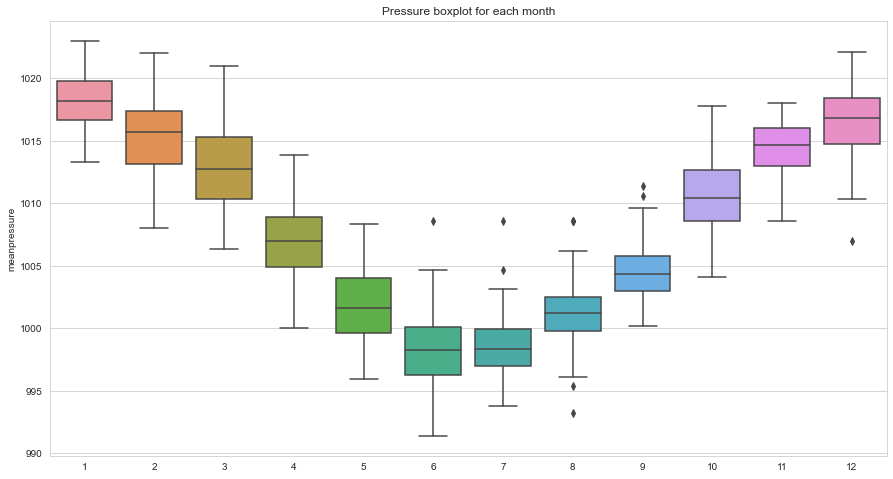

In [45]:
#Boxplots for each month
plt.figure(figsize = (15,8))
sns.set_style('whitegrid')
ax = sns.boxplot(x = months, y = pressure)
ax.set_title('Pressure boxplot for each month')
plt.show()

As it can be seen, the pressure is smaller during summer and it is bigger during winter.

---------------------------------------------  All years pressure distribution ---------------------------------------------
The best fitted distribution for the pressure data is: {'rayleigh': {'loc': 992.910332563627, 'scale': 12.060025624654564}}


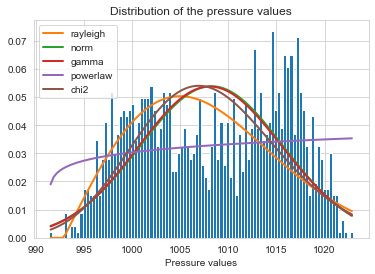

---------------------------------------------  2013 pressure distribution ---------------------------------------------
The best fitted distribution for the 2013 pressure data is: {'powerlaw': {'a': 1.1126775316308333, 'loc': 993.2384067424877, 'scale': 28.561593276032696}}


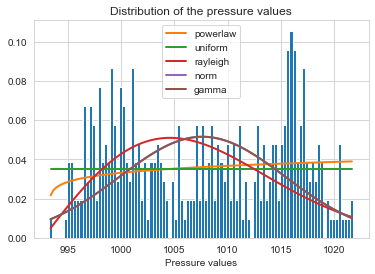

---------------------------------------------  2014 pressure distribution ---------------------------------------------
The best fitted distribution for the 2014 pressure data is: {'powerlaw': {'a': 1.2929141710238028, 'loc': 991.3264301979427, 'scale': 31.673569840617763}}


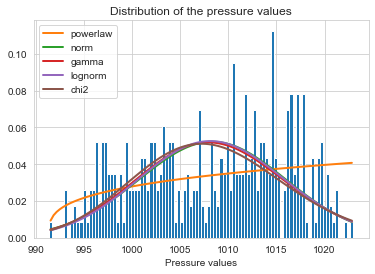

---------------------------------------------  2015 pressure distribution ---------------------------------------------
The best fitted distribution for the 2015 pressure data is: {'powerlaw': {'a': 1.2425656896512907, 'loc': 993.7156935147825, 'scale': 28.284306517871173}}


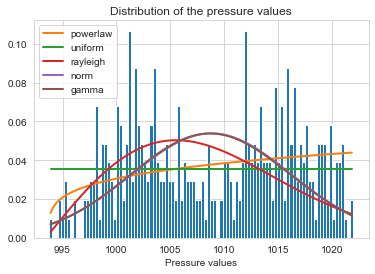

---------------------------------------------  2016 pressure distribution ---------------------------------------------
The best fitted distribution for the 2016 pressure data is: {'powerlaw': {'a': 1.0720372418916198, 'loc': 995.5545337705361, 'scale': 25.588323556160105}}


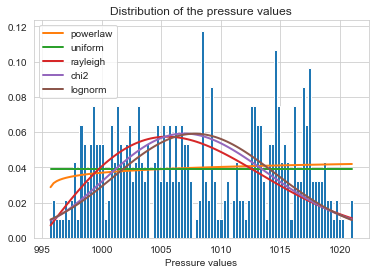

In [46]:
print('---------------------------------------------  All years pressure distribution ---------------------------------------------')
f = Fitter(pressure,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the pressure data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Pressure values')
plt.title('Distribution of the pressure values')
plt.show()

print('---------------------------------------------  2013 pressure distribution ---------------------------------------------')
f = Fitter(pres_2013,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2013 pressure data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Pressure values')
plt.title('Distribution of the pressure values')
plt.show()

print('---------------------------------------------  2014 pressure distribution ---------------------------------------------')
f = Fitter(pres_2014,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2014 pressure data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Pressure values')
plt.title('Distribution of the pressure values')
plt.show()

print('---------------------------------------------  2015 pressure distribution ---------------------------------------------')
f = Fitter(pres_2015,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2015 pressure data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Pressure values')
plt.title('Distribution of the pressure values')
plt.show()

print('---------------------------------------------  2016 pressure distribution ---------------------------------------------')
f = Fitter(pres_2016,distributions = get_common_distributions())
f.fit()
f.summary()
print('The best fitted distribution for the 2016 pressure data is:', f.get_best(method = 'sumsquare_error'))
plt.xlabel('Pressure values')
plt.title('Distribution of the pressure values')
plt.show()

Similar distributions in all years.

#### Autocorrelation plot

<Figure size 432x288 with 0 Axes>

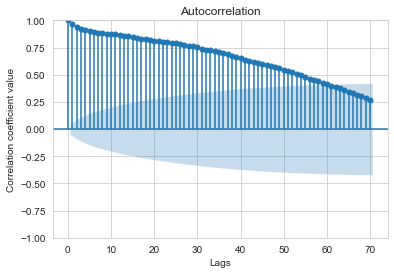

In [47]:
plt.figure()
plot_acf(x = pressure, lags=70)
plt.xlabel('Lags')
plt.ylabel('Correlation coefficient value')
plt.show()

As expected (after seeing the run plots and the boxplots for each month), the autocorrelation is linearly decreasing as the lag is increasing.

#### PSD

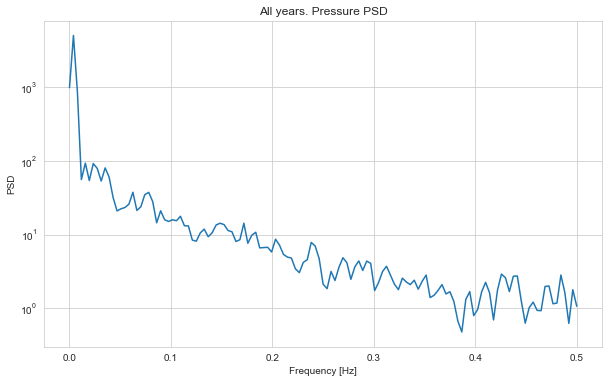

Text(0.5, 1.0, 'Pressure 2016')

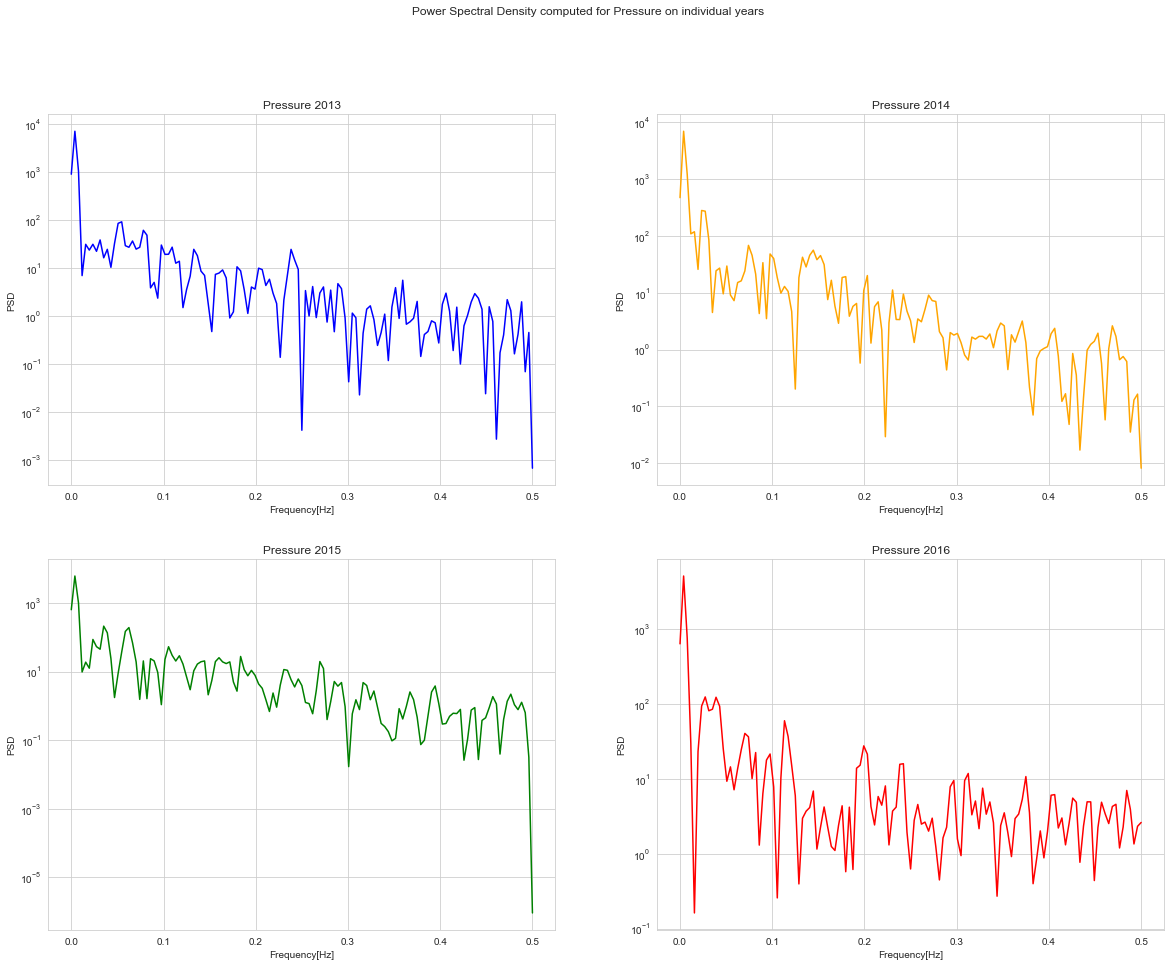

In [48]:
freq, psd = signal.welch(pressure)
plt.figure(figsize = (10,6))
plt.semilogy(freq, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('All years. Pressure PSD')
plt.show()

f_2013, p_2013 = signal.welch(pres_2013)
f_2014, p_2014 = signal.welch(pres_2014)
f_2015, p_2015 = signal.welch(pres_2015)
f_2016, p_2016 = signal.welch(pres_2016)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize = (20,15))
fig.suptitle('Power Spectral Density computed for Pressure on individual years')

ax1.semilogy(f_2013,p_2013,c='blue')
ax1.set_xlabel('Frequency[Hz]')
ax1.set_ylabel('PSD')
ax1.set_title('Pressure 2013')

ax2.semilogy(f_2014,p_2014,c='orange')
ax2.set_xlabel('Frequency[Hz]')
ax2.set_ylabel('PSD')
ax2.set_title('Pressure 2014')

ax3.semilogy(f_2015,p_2015,c='green')
ax3.set_xlabel('Frequency[Hz]')
ax3.set_ylabel('PSD')
ax3.set_title('Pressure 2015')

ax4.semilogy(f_2016,p_2016,c='red')
ax4.set_xlabel('Frequency[Hz]')
ax4.set_ylabel('PSD')
ax4.set_title('Pressure 2016')

No significant peak can be observed.

Let's see if the features are somehowe correlated between eachother.

### Features correlation (Temperature vs Humidity vs Wind Speed vs Pressure)

#### All years

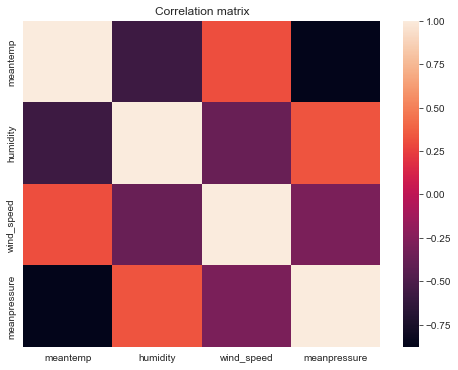

In [49]:
plt.figure(figsize = (8,6))
sns.heatmap(train_data.corr())
plt.title('Correlation matrix')
plt.show()

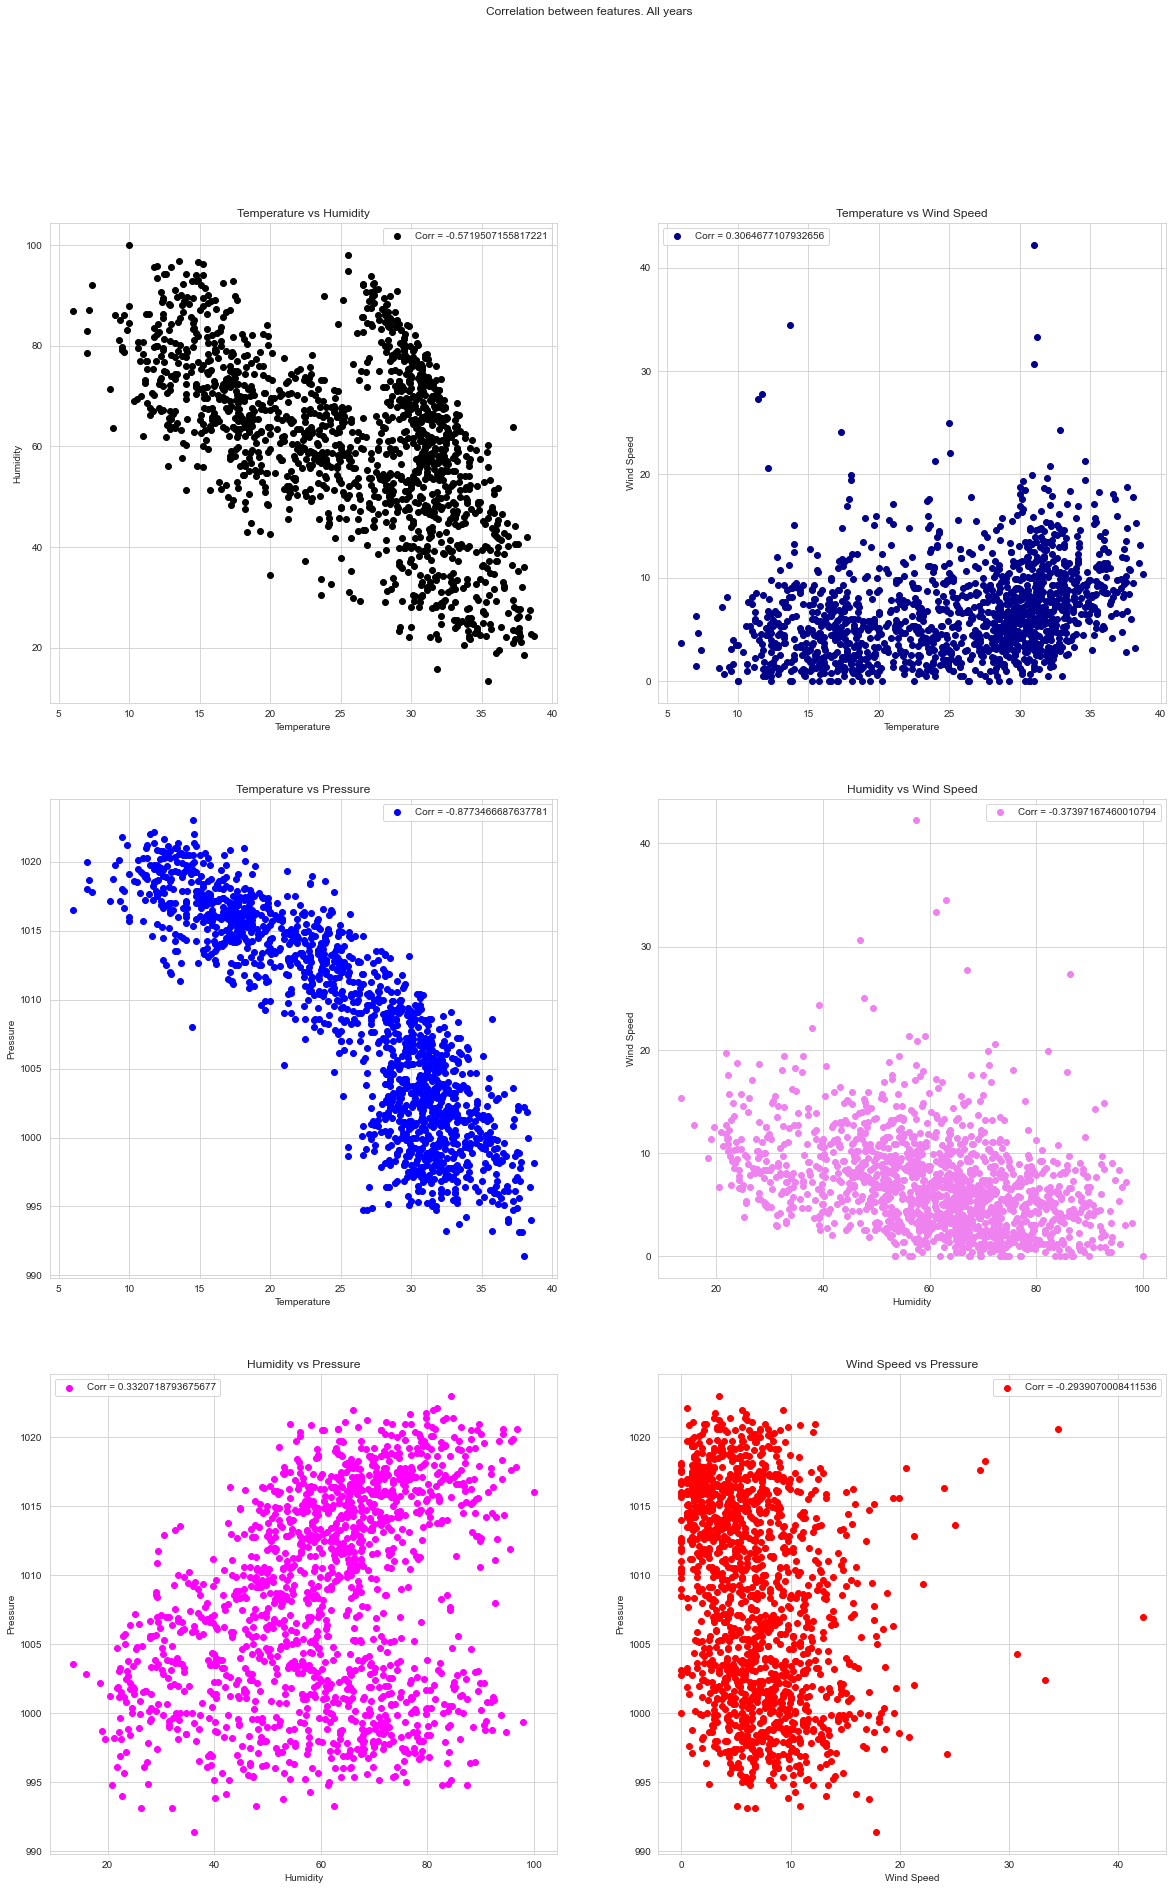

In [50]:
fig, ((ax1,ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize = (20,30))
fig.suptitle('Correlation between features. All years')

c_th, _ = stats.pearsonr(temperature,humidity)
ax1.scatter(temperature, humidity, c = 'black')
ax1.legend(['Corr = '+str(c_th)], loc = 'best')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
ax1.set_title('Temperature vs Humidity')
ax1.grid(True)

c_tw, _ = stats.pearsonr(temperature,windspeed)
ax2.scatter(temperature, windspeed, c = 'darkblue')
ax2.legend(['Corr = '+str(c_tw)], loc = 'best')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Wind Speed')
ax2.set_title('Temperature vs Wind Speed')
ax2.grid(True)

c_tp, _ = stats.pearsonr(temperature,pressure)
ax3.scatter(temperature, pressure, c = 'blue')
ax3.legend(['Corr = '+str(c_tp)], loc = 'best')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Pressure')
ax3.set_title('Temperature vs Pressure')
ax3.grid(True)

c_hw, _ = stats.pearsonr(humidity,windspeed)
ax4.scatter(humidity, windspeed, c = 'violet')
ax4.legend(['Corr = '+str(c_hw)], loc = 'best')
ax4.set_xlabel('Humidity')
ax4.set_ylabel('Wind Speed')
ax4.set_title('Humidity vs Wind Speed')
ax4.grid(True)

c_hp, _ = stats.pearsonr(humidity,pressure)
ax5.scatter(humidity, pressure, c = 'magenta')
ax5.legend(['Corr = '+str(c_hp)], loc = 'best')
ax5.set_xlabel('Humidity')
ax5.set_ylabel('Pressure')
ax5.set_title('Humidity vs Pressure')
ax5.grid(True)

c_wp, _ = stats.pearsonr(windspeed,pressure)
ax6.scatter(windspeed, pressure, c = 'red')
ax6.legend(['Corr = '+str(c_wp)], loc = 'best')
ax6.set_xlabel('Wind Speed')
ax6.set_ylabel('Pressure')
ax6.set_title('Wind Speed vs Pressure')
ax6.grid(True)

#### 2013

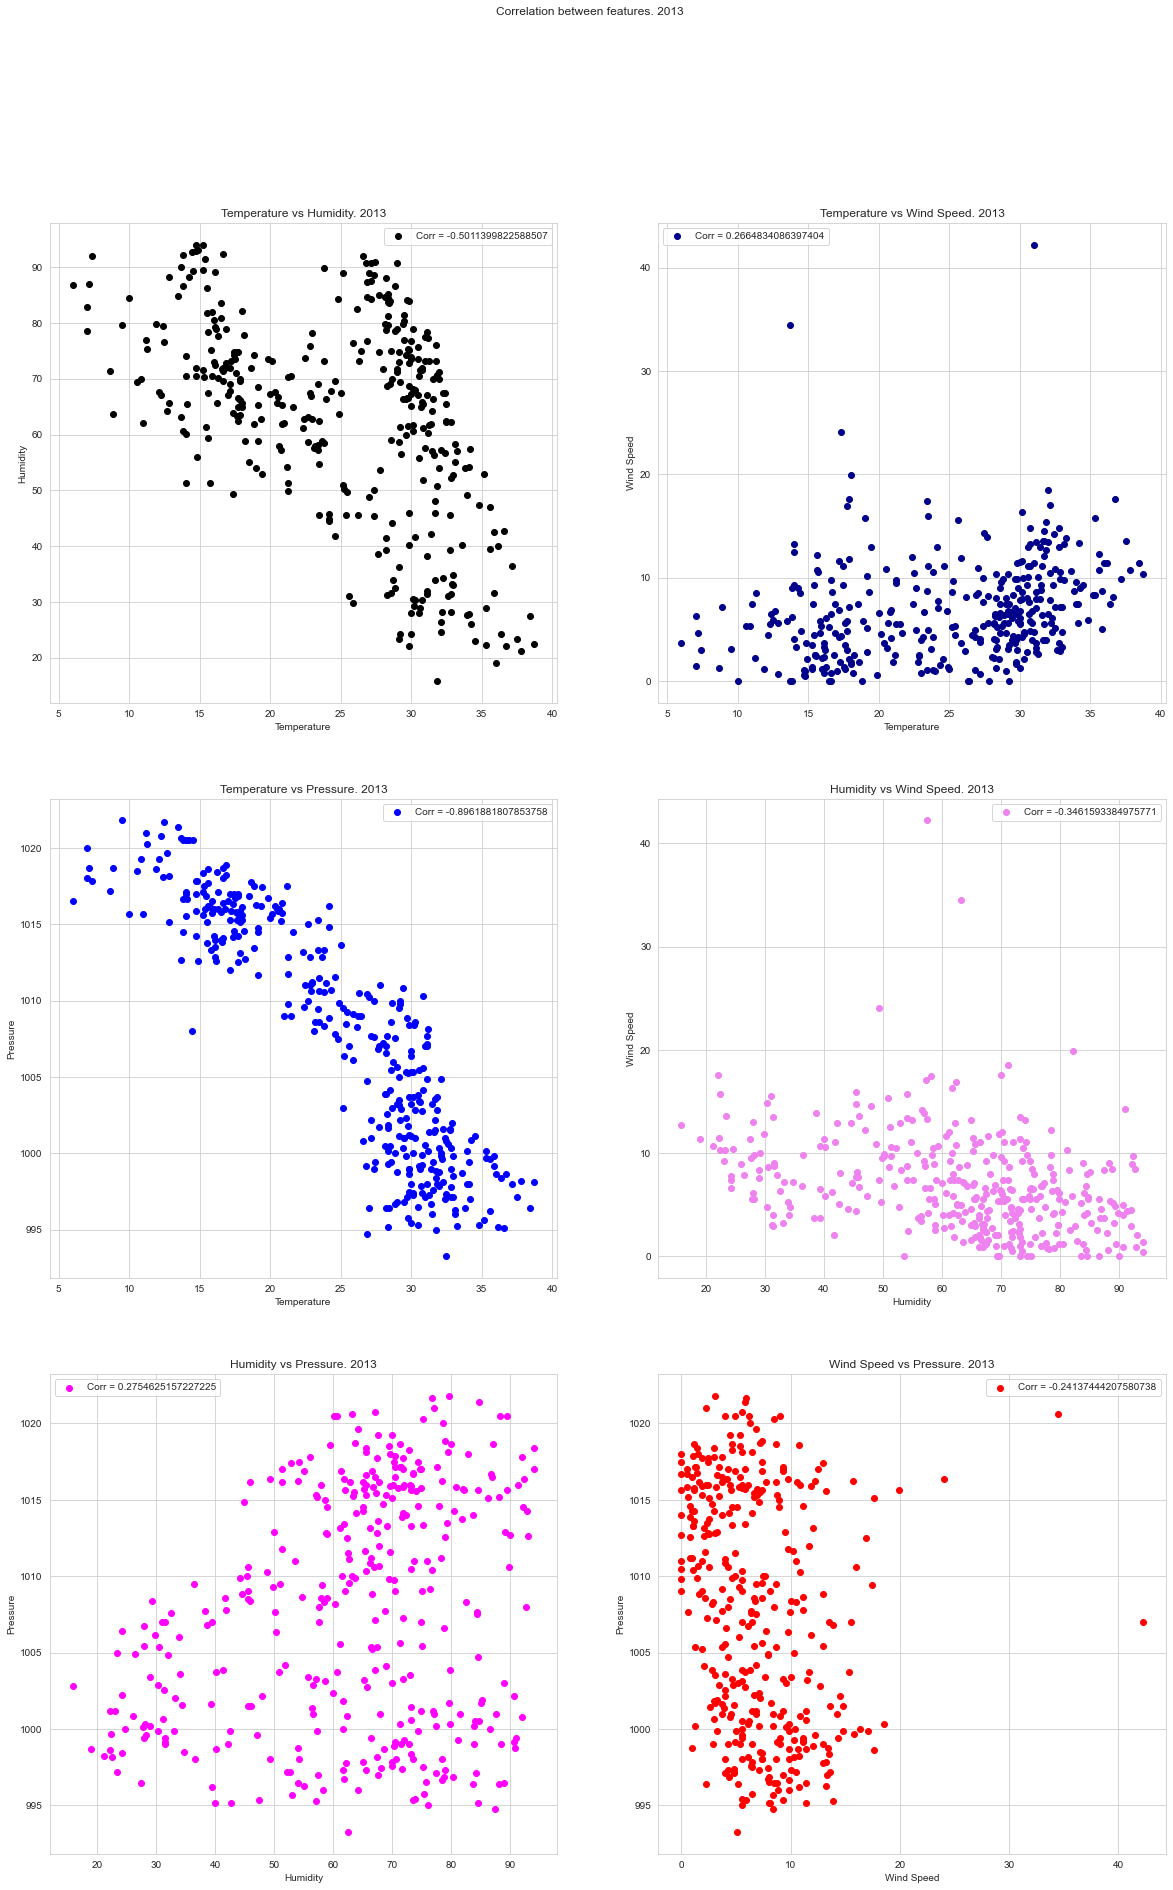

In [51]:
fig, ((ax1,ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize = (20,30))
fig.suptitle('Correlation between features. 2013')

c_th, _ = stats.pearsonr(temp_2013,hum_2013)
ax1.scatter(temp_2013, hum_2013, c = 'black')
ax1.legend(['Corr = '+str(c_th)], loc = 'best')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
ax1.set_title('Temperature vs Humidity. 2013')
ax1.grid(True)

c_tw, _ = stats.pearsonr(temp_2013,ws_2013)
ax2.scatter(temp_2013, ws_2013, c = 'darkblue')
ax2.legend(['Corr = '+str(c_tw)], loc = 'best')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Wind Speed')
ax2.set_title('Temperature vs Wind Speed. 2013')
ax2.grid(True)

c_tp, _ = stats.pearsonr(temp_2013,pres_2013)
ax3.scatter(temp_2013, pres_2013, c = 'blue')
ax3.legend(['Corr = '+str(c_tp)], loc = 'best')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Pressure')
ax3.set_title('Temperature vs Pressure. 2013')
ax3.grid(True)

c_hw, _ = stats.pearsonr(hum_2013,ws_2013)
ax4.scatter(hum_2013, ws_2013, c = 'violet')
ax4.legend(['Corr = '+str(c_hw)], loc = 'best')
ax4.set_xlabel('Humidity')
ax4.set_ylabel('Wind Speed')
ax4.set_title('Humidity vs Wind Speed. 2013')
ax4.grid(True)

c_hp, _ = stats.pearsonr(hum_2013,pres_2013)
ax5.scatter(hum_2013, pres_2013, c = 'magenta')
ax5.legend(['Corr = '+str(c_hp)], loc = 'best')
ax5.set_xlabel('Humidity')
ax5.set_ylabel('Pressure')
ax5.set_title('Humidity vs Pressure. 2013')
ax5.grid(True)

c_wp, _ = stats.pearsonr(ws_2013,pres_2013)
ax6.scatter(ws_2013, pres_2013, c = 'red')
ax6.legend(['Corr = '+str(c_wp)], loc = 'best')
ax6.set_xlabel('Wind Speed')
ax6.set_ylabel('Pressure')
ax6.set_title('Wind Speed vs Pressure. 2013')
ax6.grid(True)

#### 2014

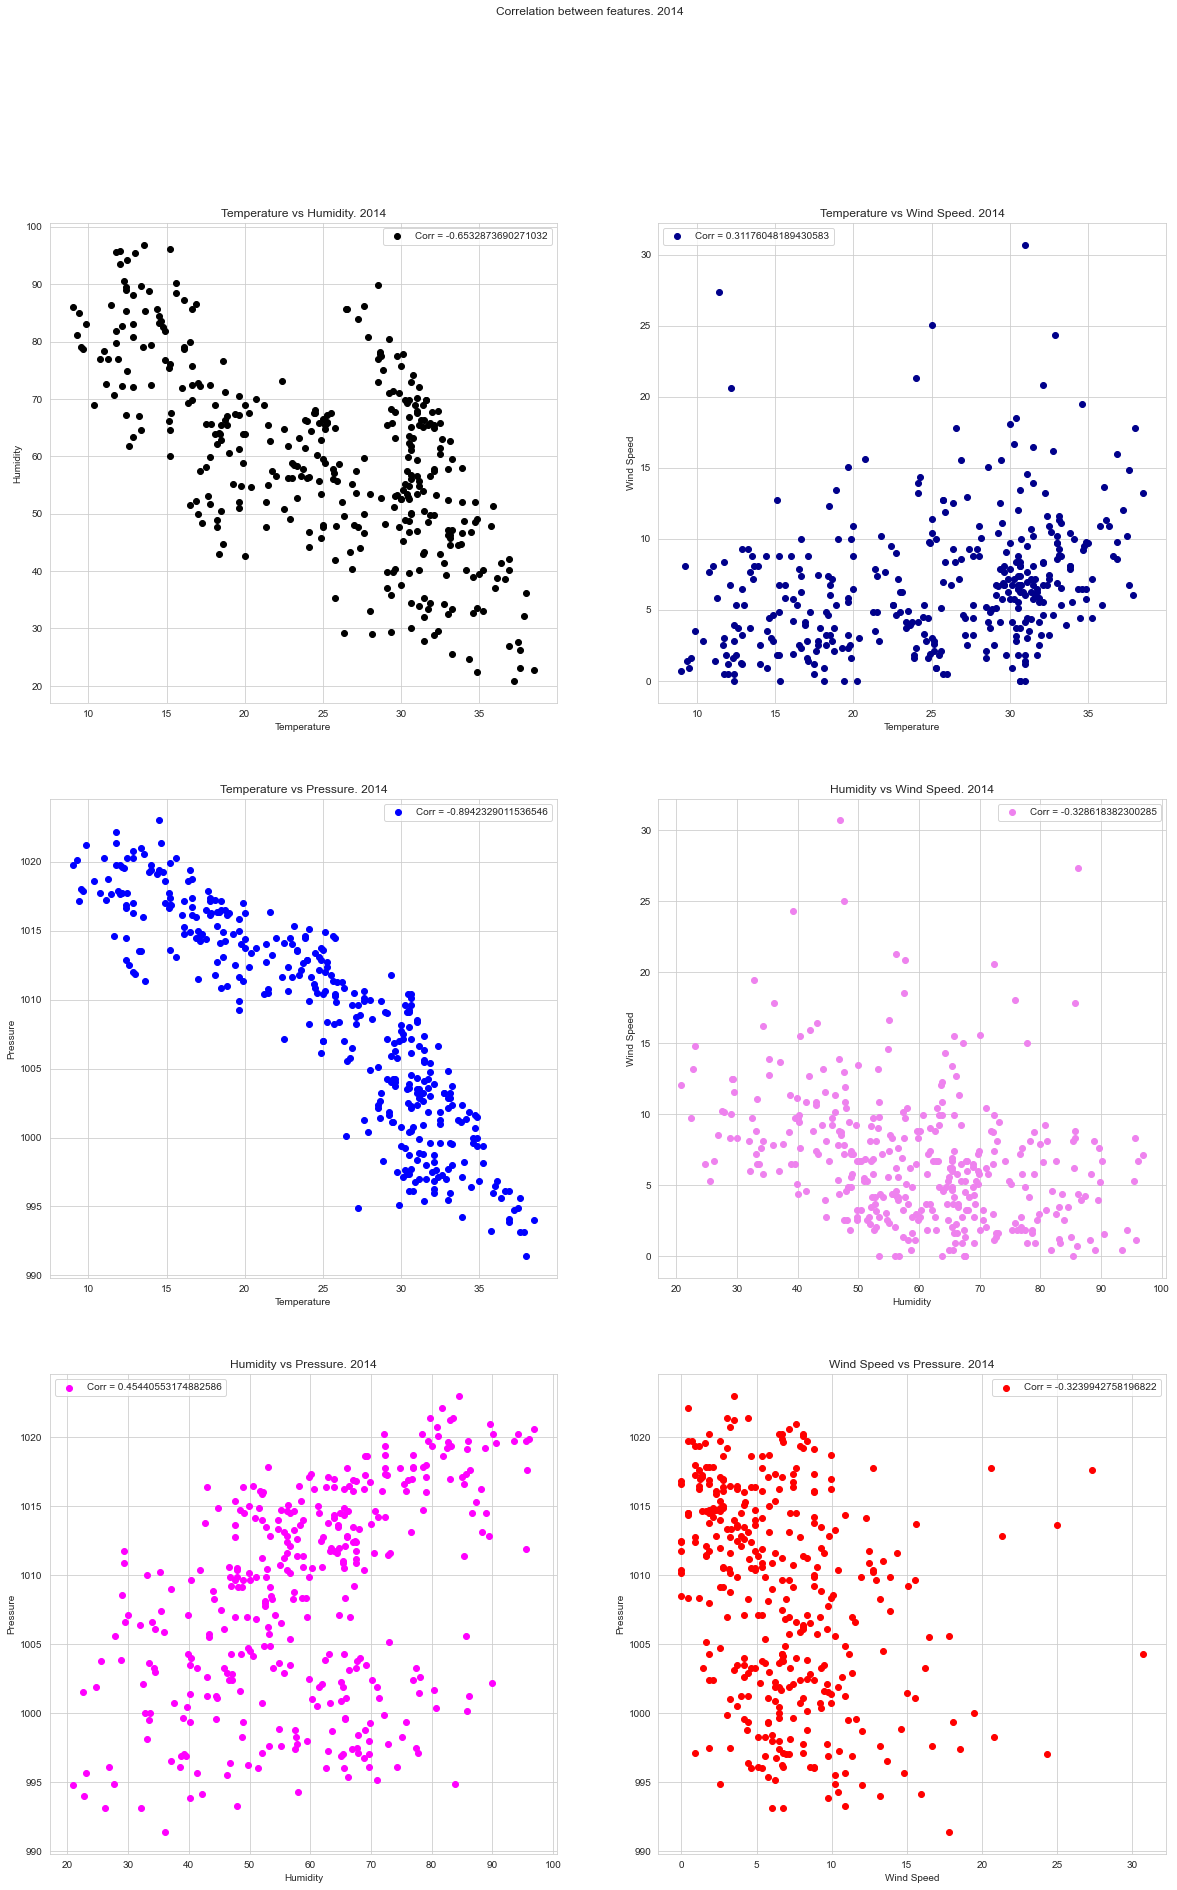

In [52]:
fig, ((ax1,ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize = (20,30))
fig.suptitle('Correlation between features. 2014')

c_th, _ = stats.pearsonr(temp_2014,hum_2014)
ax1.scatter(temp_2014, hum_2014, c = 'black')
ax1.legend(['Corr = '+str(c_th)], loc = 'best')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
ax1.set_title('Temperature vs Humidity. 2014')
ax1.grid(True)

c_tw, _ = stats.pearsonr(temp_2014,ws_2014)
ax2.scatter(temp_2014, ws_2014, c = 'darkblue')
ax2.legend(['Corr = '+str(c_tw)], loc = 'best')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Wind Speed')
ax2.set_title('Temperature vs Wind Speed. 2014')
ax2.grid(True)

c_tp, _ = stats.pearsonr(temp_2014,pres_2014)
ax3.scatter(temp_2014, pres_2014, c = 'blue')
ax3.legend(['Corr = '+str(c_tp)], loc = 'best')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Pressure')
ax3.set_title('Temperature vs Pressure. 2014')
ax3.grid(True)

c_hw, _ = stats.pearsonr(hum_2014,ws_2014)
ax4.scatter(hum_2014, ws_2014, c = 'violet')
ax4.legend(['Corr = '+str(c_hw)], loc = 'best')
ax4.set_xlabel('Humidity')
ax4.set_ylabel('Wind Speed')
ax4.set_title('Humidity vs Wind Speed. 2014')
ax4.grid(True)

c_hp, _ = stats.pearsonr(hum_2014,pres_2014)
ax5.scatter(hum_2014, pres_2014, c = 'magenta')
ax5.legend(['Corr = '+str(c_hp)], loc = 'best')
ax5.set_xlabel('Humidity')
ax5.set_ylabel('Pressure')
ax5.set_title('Humidity vs Pressure. 2014')
ax5.grid(True)

c_wp, _ = stats.pearsonr(ws_2014,pres_2014)
ax6.scatter(ws_2014, pres_2014, c = 'red')
ax6.legend(['Corr = '+str(c_wp)], loc = 'best')
ax6.set_xlabel('Wind Speed')
ax6.set_ylabel('Pressure')
ax6.set_title('Wind Speed vs Pressure. 2014')
ax6.grid(True)

#### 2015

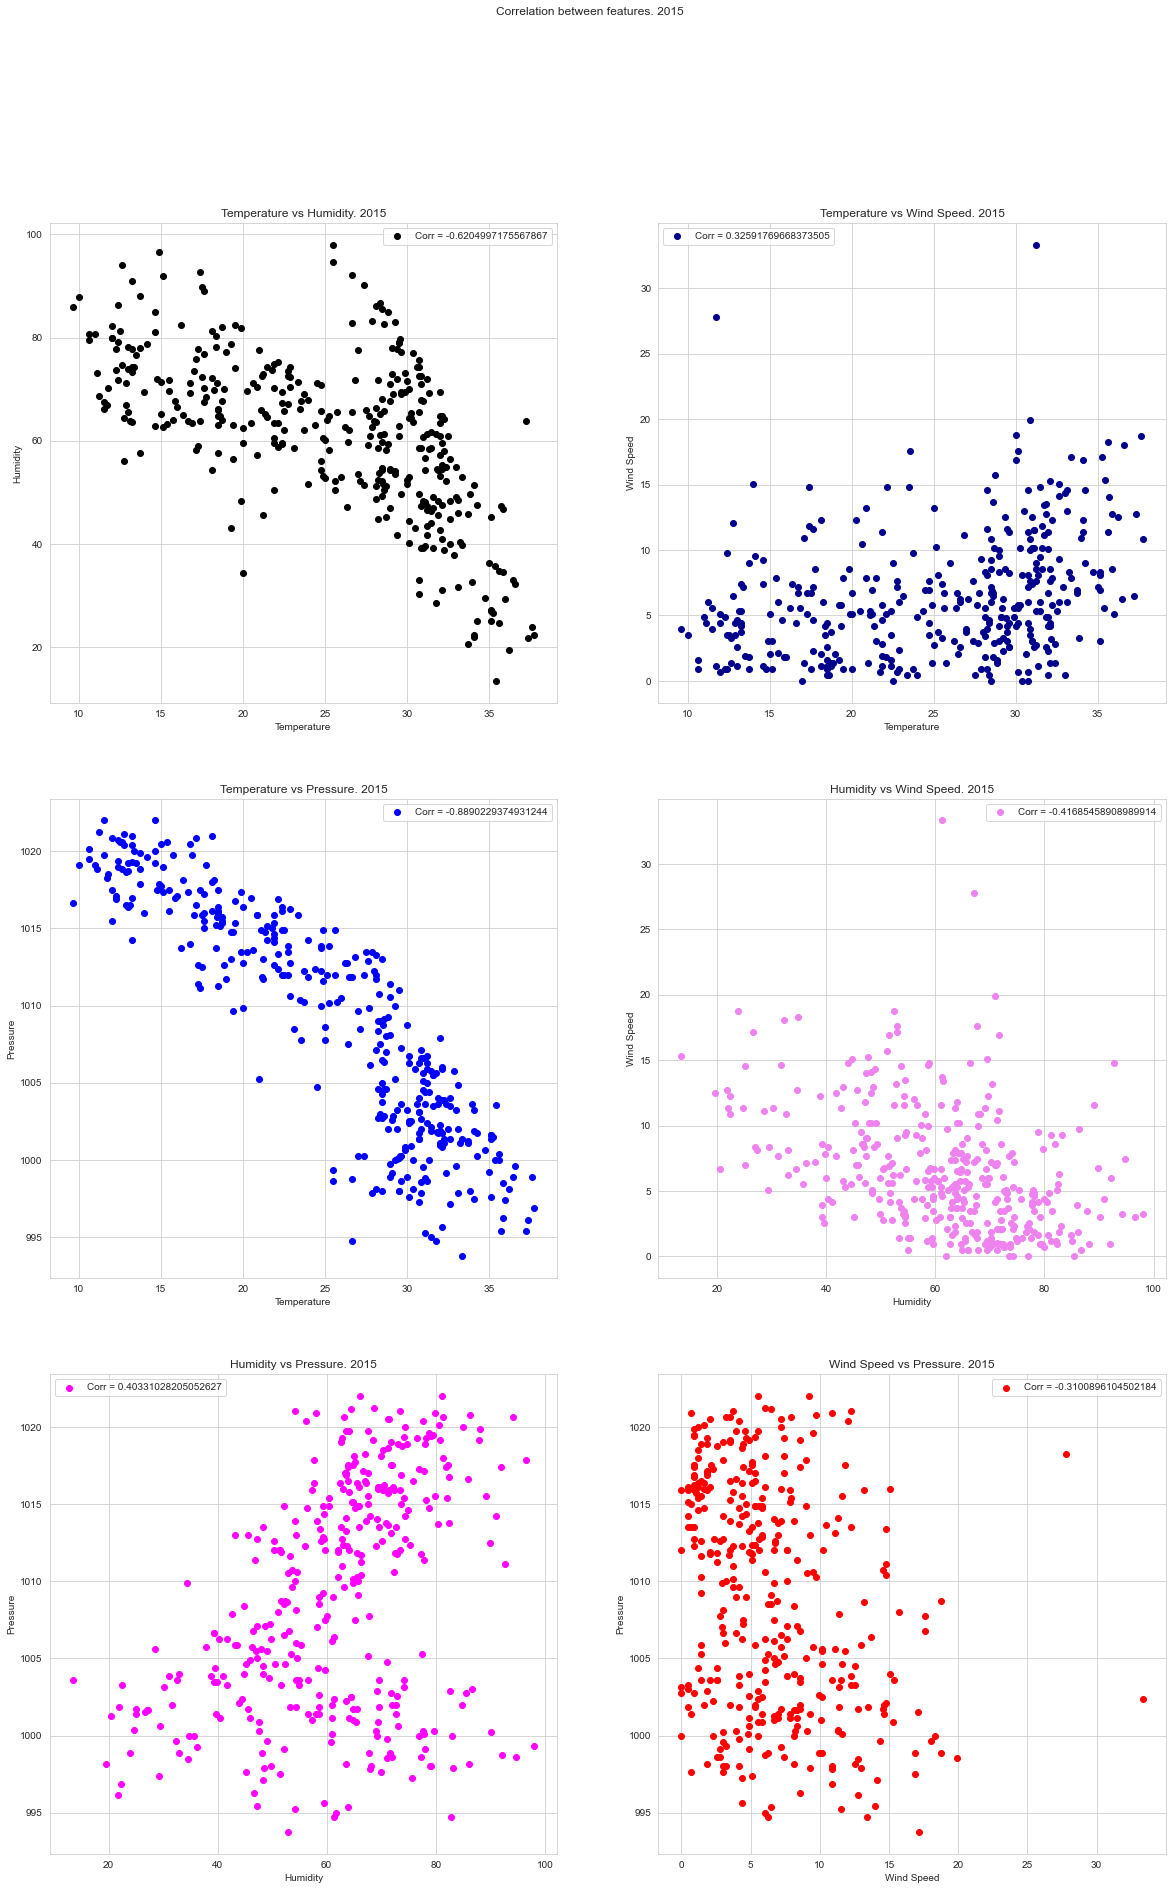

In [53]:
fig, ((ax1,ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize = (20,30))
fig.suptitle('Correlation between features. 2015')

c_th, _ = stats.pearsonr(temp_2015,hum_2015)
ax1.scatter(temp_2015, hum_2015, c = 'black')
ax1.legend(['Corr = '+str(c_th)], loc = 'best')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
ax1.set_title('Temperature vs Humidity. 2015')
ax1.grid(True)

c_tw, _ = stats.pearsonr(temp_2015,ws_2015)
ax2.scatter(temp_2015, ws_2015, c = 'darkblue')
ax2.legend(['Corr = '+str(c_tw)], loc = 'best')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Wind Speed')
ax2.set_title('Temperature vs Wind Speed. 2015')
ax2.grid(True)

c_tp, _ = stats.pearsonr(temp_2015,pres_2015)
ax3.scatter(temp_2015, pres_2015, c = 'blue')
ax3.legend(['Corr = '+str(c_tp)], loc = 'best')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Pressure')
ax3.set_title('Temperature vs Pressure. 2015')
ax3.grid(True)

c_hw, _ = stats.pearsonr(hum_2015,ws_2015)
ax4.scatter(hum_2015, ws_2015, c = 'violet')
ax4.legend(['Corr = '+str(c_hw)], loc = 'best')
ax4.set_xlabel('Humidity')
ax4.set_ylabel('Wind Speed')
ax4.set_title('Humidity vs Wind Speed. 2015')
ax4.grid(True)

c_hp, _ = stats.pearsonr(hum_2015,pres_2015)
ax5.scatter(hum_2015, pres_2015, c = 'magenta')
ax5.legend(['Corr = '+str(c_hp)], loc = 'best')
ax5.set_xlabel('Humidity')
ax5.set_ylabel('Pressure')
ax5.set_title('Humidity vs Pressure. 2015')
ax5.grid(True)

c_wp, _ = stats.pearsonr(ws_2015,pres_2015)
ax6.scatter(ws_2015, pres_2015, c = 'red')
ax6.legend(['Corr = '+str(c_wp)], loc = 'best')
ax6.set_xlabel('Wind Speed')
ax6.set_ylabel('Pressure')
ax6.set_title('Wind Speed vs Pressure. 2015')
ax6.grid(True)

#### 2016

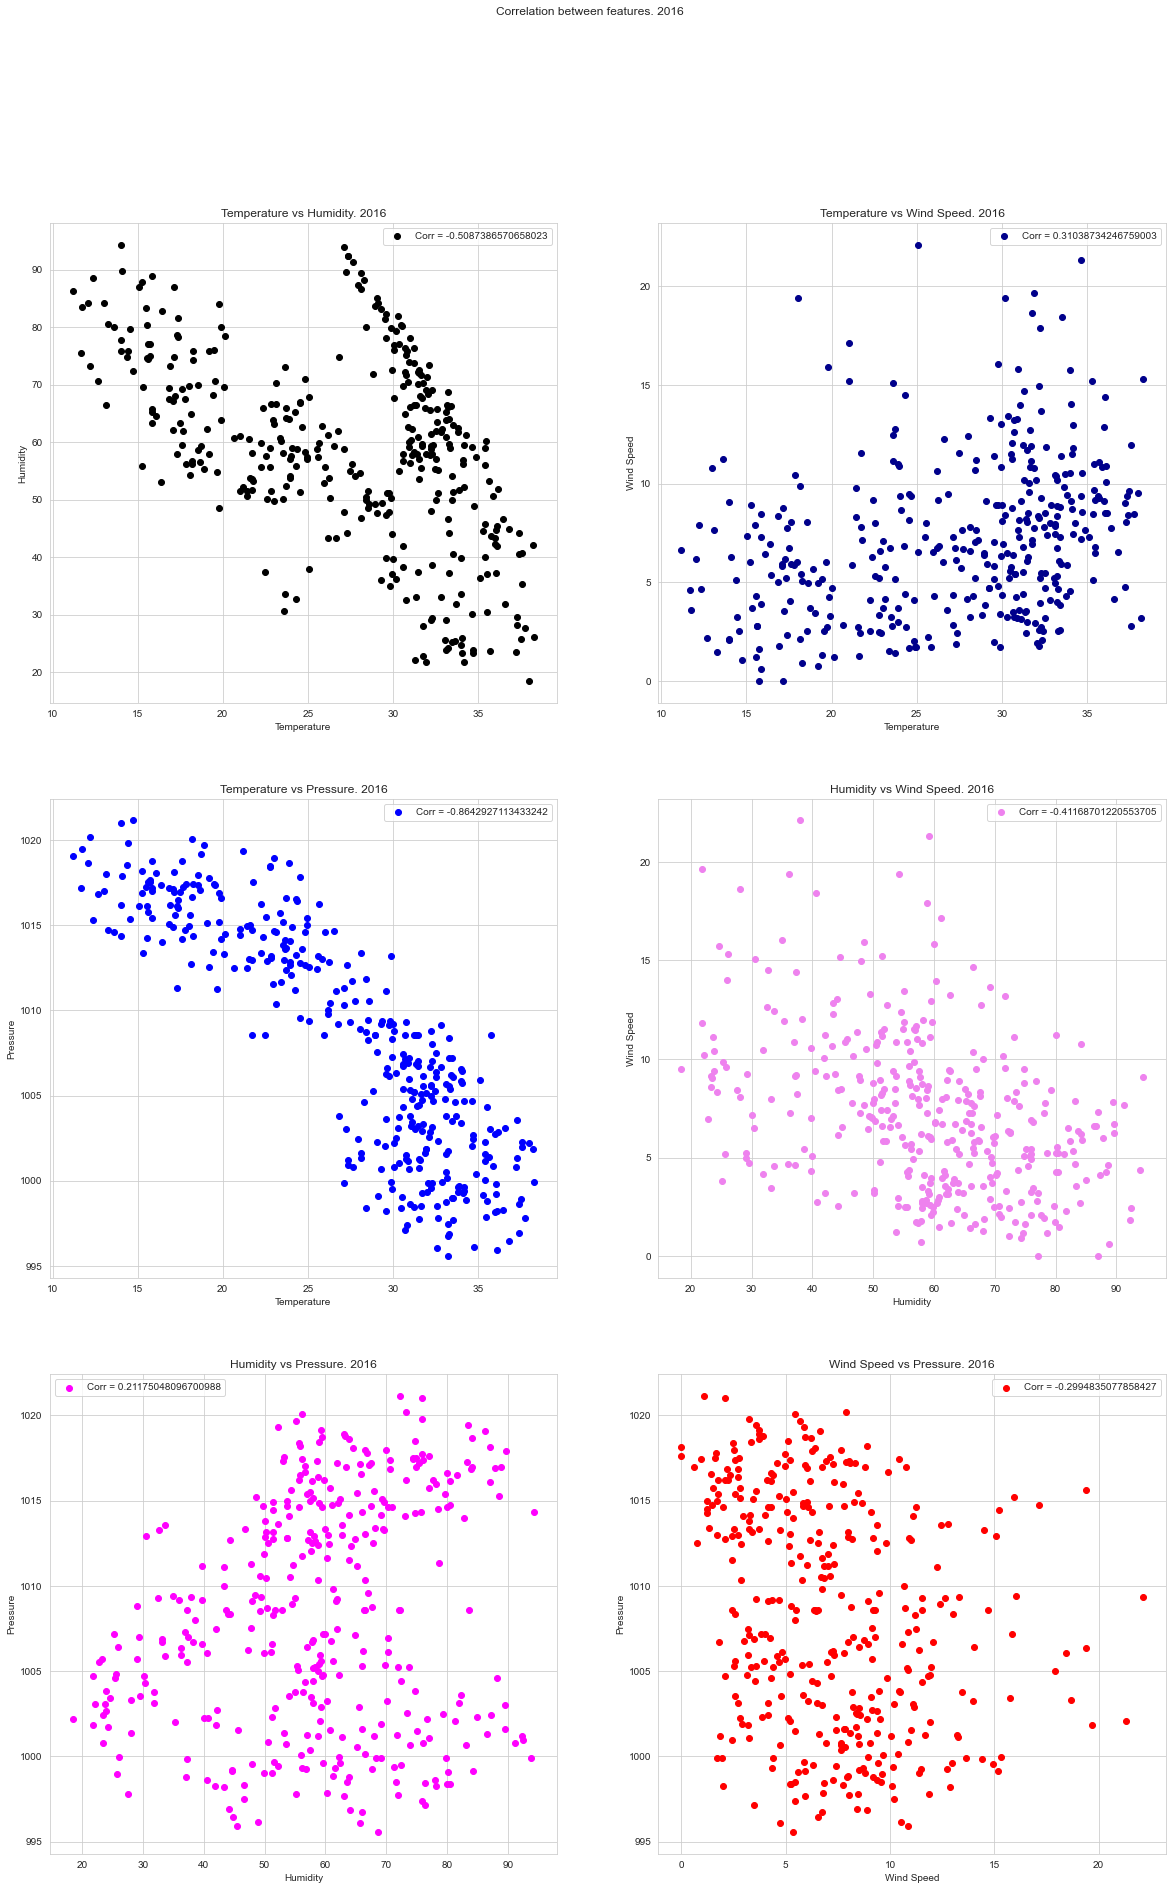

In [54]:
fig, ((ax1,ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize = (20,30))
fig.suptitle('Correlation between features. 2016')

c_th, _ = stats.pearsonr(temp_2016,hum_2016)
ax1.scatter(temp_2016, hum_2016, c = 'black')
ax1.legend(['Corr = '+str(c_th)], loc = 'best')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
ax1.set_title('Temperature vs Humidity. 2016')
ax1.grid(True)

c_tw, _ = stats.pearsonr(temp_2016,ws_2016)
ax2.scatter(temp_2016, ws_2016, c = 'darkblue')
ax2.legend(['Corr = '+str(c_tw)], loc = 'best')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Wind Speed')
ax2.set_title('Temperature vs Wind Speed. 2016')
ax2.grid(True)

c_tp, _ = stats.pearsonr(temp_2016,pres_2016)
ax3.scatter(temp_2016, pres_2016, c = 'blue')
ax3.legend(['Corr = '+str(c_tp)], loc = 'best')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Pressure')
ax3.set_title('Temperature vs Pressure. 2016')
ax3.grid(True)

c_hw, _ = stats.pearsonr(hum_2016,ws_2016)
ax4.scatter(hum_2016, ws_2016, c = 'violet')
ax4.legend(['Corr = '+str(c_hw)], loc = 'best')
ax4.set_xlabel('Humidity')
ax4.set_ylabel('Wind Speed')
ax4.set_title('Humidity vs Wind Speed. 2016')
ax4.grid(True)

c_hp, _ = stats.pearsonr(hum_2016,pres_2016)
ax5.scatter(hum_2016, pres_2016, c = 'magenta')
ax5.legend(['Corr = '+str(c_hp)], loc = 'best')
ax5.set_xlabel('Humidity')
ax5.set_ylabel('Pressure')
ax5.set_title('Humidity vs Pressure. 2016')
ax5.grid(True)

c_wp, _ = stats.pearsonr(ws_2016,pres_2016)
ax6.scatter(ws_2016, pres_2016, c = 'red')
ax6.legend(['Corr = '+str(c_wp)], loc = 'best')
ax6.set_xlabel('Wind Speed')
ax6.set_ylabel('Pressure')
ax6.set_title('Wind Speed vs Pressure. 2016')
ax6.grid(True)

Strong negative correlation between temperature and pressure and significant negative correlation between temperature and humidity (observed in all years).

## Models

Now, let's train three different models: SGPR (Spase Gaussian Process Regresion), XGBoost (xtreme Gradient Boost) and RF (Random Forest) and predict the temperature based on the humidity, wind speed and pressure. Also I'll compare all the models accuracy (also with the unoptimized version of the model).

Let's prepare the train and test data.

In [55]:
X_train = np.vstack((train_data['humidity'],train_data['wind_speed'],train_data['meanpressure'])).T
y_train = np.array(train_data['meantemp']).reshape(-1,1)
X_test = np.vstack((test_data['humidity'],test_data['wind_speed'],test_data['meanpressure'])).T
y_test = np.array(test_data['meantemp']).reshape(-1,1)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1462, 3)
(1462, 1)
(114, 3)
(114, 1)


For accuracy, I'll use the mape metric.

In [57]:
def mape(y_a,y_p):
    val = np.mean(np.abs(((y_a-y_p)/y_a)))*100
    return val

### SGPR (Sparse Gaussian Process Regression)

In [58]:
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

In [59]:
#kernel
k1 = gpflow.kernels.Matern12()

In [60]:
#unoptimized
m1 = gpflow.models.sgpr.SGPR_with_posterior(data = (X_train, y_train), kernel = k1, inducing_variable = X_train[::2])

In [61]:
#kernel
k2 = gpflow.kernels.Matern12()

In [63]:
#optimized
m2 = gpflow.models.sgpr.SGPR_with_posterior(data = (X_train, y_train), kernel = k2, inducing_variable = X_train[::2])
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m2.training_loss, m2.trainable_variables, options=dict(maxiter=100))

In [64]:
y_pred_sgpr_unopt, _ = m1.predict_f(X_test)

In [65]:
y_pred_sgpr_opt, _ = m2.predict_f(X_test)

In [66]:
print('MAPE for unoptimized SGPR model:',mape(y_test,y_pred_sgpr_unopt))
print('MAPE for optimized SGPR model:',mape(y_test,y_pred_sgpr_opt))
acc_sgpr_unopt = round(100-mape(y_test,y_pred_sgpr_unopt),2)
acc_sgpr_opt = round(100-mape(y_test,y_pred_sgpr_opt),2)
print('Accuracy for the unoptimized SGPR model:', acc_sgpr_unopt,'%')
print('Accuracy for the optimized SGPR model:', acc_sgpr_opt,'%')

MAPE for unoptimized SGPR model: 60.78511036931625
MAPE for optimized SGPR model: 13.923865053784153
Accuracy for the unoptimized SGPR model: 39.21 %
Accuracy for the optimized SGPR model: 86.08 %


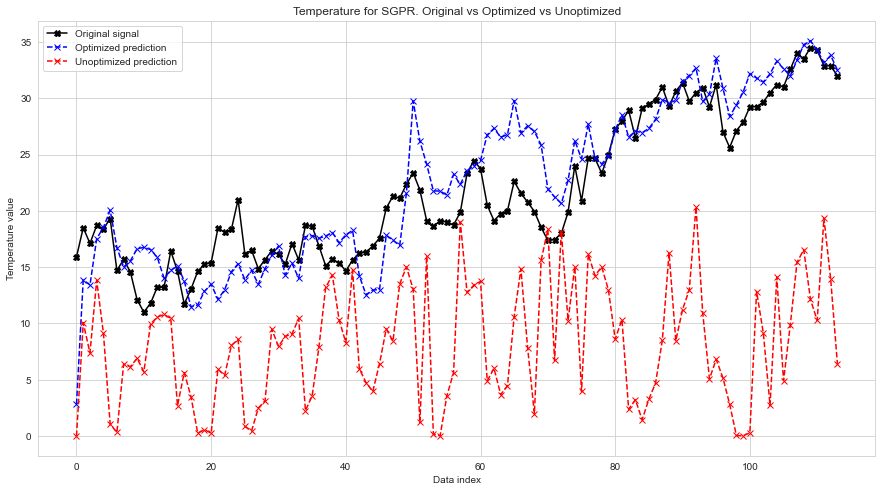

In [67]:
plt.figure(figsize = (15,8))
plt.plot(y_test,'-kX')
plt.plot(y_pred_sgpr_opt,'--bx')
plt.plot(y_pred_sgpr_unopt,'--rx')
plt.xlabel('Data index')
plt.ylabel('Temperature value')
plt.title('Temperature for SGPR. Original vs Optimized vs Unoptimized')
plt.legend(['Original signal','Optimized prediction','Unoptimized prediction'], loc='best')
plt.show()

### XGBoost

In [68]:
import xgboost as xgb
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [69]:
m3 = xgb.XGBRegressor()
m3.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

Hypermparameters tuning (Bayesian Optimization with HYPEROPT)

In [70]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, anneal
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [115]:
space_xgb={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators' : hp.quniform('n_estimators',100,500,1),
        'seed': 0
       
    }

In [116]:
def hyperparameter_tuning_xgb(space_xgb):
    model4 = xgb.XGBRegressor(n_estimators =int(space_xgb['n_estimators']), max_depth = int(space_xgb['max_depth']), gamma = space_xgb['gamma'],
                    reg_alpha = int(space_xgb['reg_alpha']), reg_lambda = int(space_xgb['reg_lambda']),
                    min_child_weight=int(space_xgb['min_child_weight']), 
                    colsample_bytree=int(space_xgb['colsample_bytree']))
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model4.fit(X_train, y_train, eval_set=evaluation, eval_metric="rmse", early_stopping_rounds=100, verbose=False)
    pred = model4.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    return {'loss':rmse, 'status': STATUS_OK, 'model': model4}

In [117]:
trials4 = Trials()
best_hyperparam_xgb = fmin(fn=hyperparameter_tuning_xgb, space=space_xgb, algo=tpe.suggest, max_evals=100, trials=trials4)

SCORE:                                                 
3.277728648863143                                      
SCORE:                                                 
3.2201593255846226                                                              
SCORE:                                                                           
3.1049096481489245                                                               
SCORE:                                                                           
3.277685818017377                                                                
SCORE:                                                                           
3.248813749621417                                                                
SCORE:                                                                           
3.2884940748667546                                                               
SCORE:                                                                           
3.24650010672

3.2652534727635625                                                               
100%|██████████| 100/100 [00:08<00:00, 11.25trial/s, best loss: 2.961155959459024]


In [118]:
m4 = trials4.results[np.argmin([r['loss'] for r in trials4.results])]['model']

In [119]:
y_pred_xgb_unopt = m3.predict(X_test)

In [120]:
y_pred_xgb_opt = m4.predict(X_test)

In [121]:
print('MAPE for unoptimized XGB model:',mape(y_test,y_pred_xgb_unopt))
print('MAPE for optimized XGB model:',mape(y_test,y_pred_xgb_opt))
acc_xgb_unopt = round(100-mape(y_test,y_pred_xgb_unopt),2)
acc_xgb_opt = round(100-mape(y_test,y_pred_xgb_opt),2)
print('Accuracy for the unoptimized XGB model:', acc_xgb_unopt,'%')
print('Accuracy for the optimized XGB model:', acc_xgb_opt,'%')

MAPE for unoptimized XGB model: 39.61685519600723
MAPE for optimized XGB model: 32.22793827067526
Accuracy for the unoptimized XGB model: 60.38 %
Accuracy for the optimized XGB model: 67.77 %


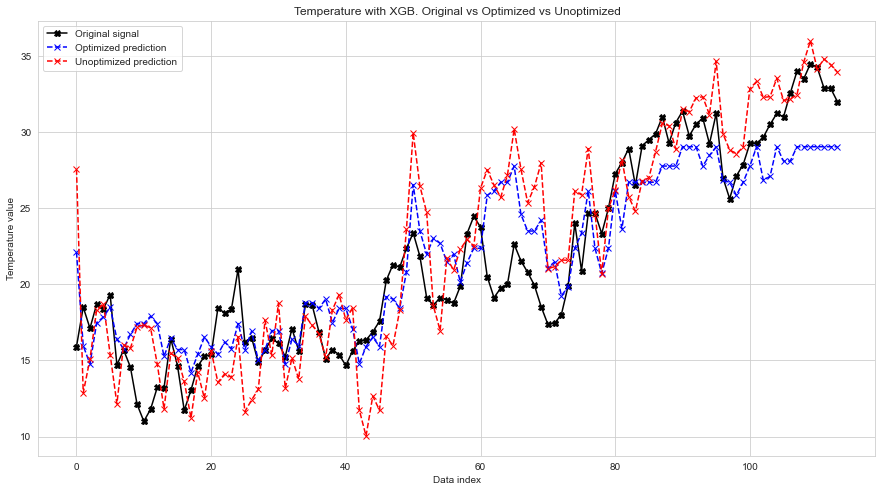

In [114]:
plt.figure(figsize = (15,8))
plt.plot(y_test,'-kX')
plt.plot(y_pred_xgb_opt,'--bx')
plt.plot(y_pred_xgb_unopt,'--rx')
plt.xlabel('Data index')
plt.ylabel('Temperature value')
plt.title('Temperature with XGB. Original vs Optimized vs Unoptimized')
plt.legend(['Original signal','Optimized prediction','Unoptimized prediction'], loc='best')
plt.show()

### Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [80]:
m5 = RandomForestRegressor(n_estimators = 100, random_state = 0)
m5.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Hypermparameters tuning (Bayesian Optimization with HYPEROPT)

In [81]:
# def_objective(space_rf):
#     nr_est = int(space_rf['n_estimators'])
#     max_dp = int(space_rf['max_depth'])
#     min_samp_l = int(space_rf['min_samples_leaf'])
#     min_samp = int(space_rf['min_samples_split'])
#     max_ft = int(space_rf['max_features'])
#     model6 = RandomForestRegressor(n_estimators = nr_est, max_depth = max_dp, min_samples_leaf = min_samp_l, min_samples_split = min_samp, max_features = max_ft)
#     p

In [89]:
space_rf = {'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',1,20),
           'max_features':hp.uniform('max_features',1,5),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,10),
           'min_samples_split':hp.uniform('min_samples_split',1,10)}

In [90]:
def hyperparameter_tuning_rf(space_rf):
    model6 = RandomForestRegressor(n_estimators = int(space_rf['n_estimators']), max_depth = int(space_rf['max_depth']),
                                   max_features = int(space_rf['max_features']),
                                   min_samples_leaf = int(space_rf['min_samples_leaf']),
                                   min_samples_split = int(space_rf['min_samples_split']))
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model6.fit(X_train, y_train)
    pred = model6.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    print ("SCORE:", rmse)
    return {'loss':rmse, 'status': STATUS_OK, 'model': model6}

In [91]:
trials6 = Trials()
best_hyperparam_rf = fmin(fn=hyperparameter_tuning_rf, space=space_rf, algo=tpe.suggest, max_evals=100, trials=trials6)

SCORE:                                                 
3.4460892169105497                                     
SCORE:                                                                           
3.4993029736689114                                                               
SCORE:                                                                           
3.5081005693207015                                                               
SCORE:                                                                           
3.4048839210355593                                                               
SCORE:                                                                           
3.3959202326884594                                                               
SCORE:                                                                           
3.454403615731775                                                                
SCORE:                                                              

3.445804320347192                                                                
SCORE:                                                                           
3.432748474003233                                                                
100%|██████████| 100/100 [01:45<00:00,  1.06s/trial, best loss: 3.392768550028639]


In [92]:
m6 = trials6.results[np.argmin([r['loss'] for r in trials6.results])]['model']

In [93]:
y_pred_rf_unopt = m5.predict(X_test)

In [94]:
y_pred_rf_opt = m6.predict(X_test)

In [95]:
print('MAPE for unoptimized RF model:',mape(y_test,y_pred_rf_unopt))
print('MAPE for optimized RF model:',mape(y_test,y_pred_rf_opt))
acc_rf_unopt = round(100-mape(y_test,y_pred_rf_unopt),2)
acc_rf_opt = round(100-mape(y_test,y_pred_rf_opt),2)
print('Accuracy for the unoptimized RF model:', acc_rf_unopt,'%')
print('Accuracy for the optimized RF model:', acc_rf_opt,'%')

MAPE for unoptimized RF model: 38.931665729633565
MAPE for optimized RF model: 38.104116882958095
Accuracy for the unoptimized RF model: 61.07 %
Accuracy for the optimized RF model: 61.9 %


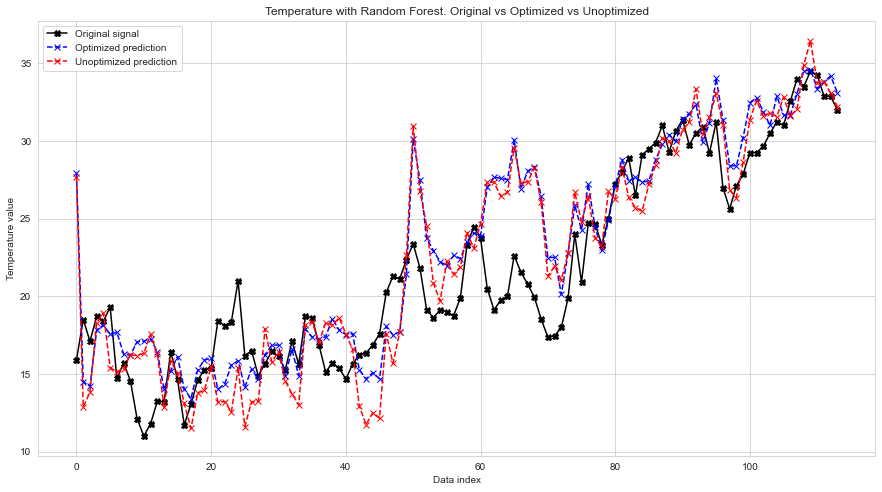

In [96]:
plt.figure(figsize = (15,8))
plt.plot(y_test,'-kX')
plt.plot(y_pred_rf_opt,'--bx')
plt.plot(y_pred_rf_unopt,'--rx')
plt.xlabel('Data index')
plt.ylabel('Temperature value')
plt.title('Temperature with Random Forest. Original vs Optimized vs Unoptimized')
plt.legend(['Original signal','Optimized prediction','Unoptimized prediction'], loc='best')
plt.show()

### Results

Visualization of the accuracy results for all models

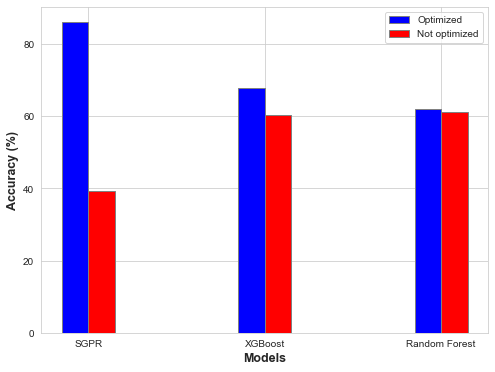

In [123]:
accuracy_unopt = [acc_sgpr_unopt, acc_xgb_unopt, acc_rf_unopt]
accuracy_opt = [acc_sgpr_opt, acc_xgb_opt, acc_rf_opt]

barWidth = 0.15
br1 = np.arange(len(accuracy_opt))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(8, 6))
plt.bar(br1, accuracy_opt, color = 'blue', width = barWidth, edgecolor = 'grey', label = 'Optimized')
plt.bar(br2, accuracy_unopt, color = 'red', width = barWidth, edgecolor = 'grey', label = 'Not optimized')
plt.xlabel('Models', fontweight ='bold', fontsize = 12.5)
plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 12.5)
plt.xticks([r + barWidth/2 for r in range(len(accuracy_opt))], ['SGPR', 'XGBoost', 'Random Forest'])
plt.legend(loc = 'best')
plt.show()

## Conclusions

1. The optimizing process worked significantly for SGPR and XGBoost. The optimization improvement for SGPR model is obvious: from 39% accuracy to 86% accuracy, beeing the best improvement in terms of accuracy for all the models. The Basyesian Optimization with HYPEROPT provided a great 7% improvement for the XGB model accuracy, but only a 0.8% improvement for the RF model.
2. The SGPR model provided the best accuracy (86%) after optimization, which provides another argument that the Gaussian Process Regression model fits in an accurate manner different data sets.
3. Further work: better tunning for RF hyperparameters.